## Used Cars (EDA, DNN, ML, XAI, Ensemble, R2: 90%)

**Research ideas**
- Analyze the relationship between car prices and age (year of registration) using a linear regression model to suggest which cars provide the best value for money.
- Use classification models to predict vehicle types based on features like powerPS, price, brand, etc.
- Compare and contrast seller types (private vs dealer) by analyzing prices, seller locations and other geographic information in order to give advice on which type of seller provides the best deals for customers
------------------
* EDA: Exploratory Data Analysis

I'm going to train different models in order to predict the price of a used car based on other features:

* DNN: Deep Neural Network
* ML: Machine Learning (Methods for Regression)
* XAI: Explainable AI (using SHAP)
* Ensemble Learning





In [91]:

import warnings, ydata_profiling, shap
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer



import tensorflow 
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam




from tqdm import tqdm
from colorama import Fore, Back, Style

sns.set_style('dark')
warnings.filterwarnings('ignore')
shap.initjs()

In [4]:
df = pd.read_csv("/kaggle/input/uncovering-factors-that-affect-used-car-prices/autos.csv")
df.head()

index          dateCrawled                            name  seller   
0      0  2016-03-24 11:52:17                      Golf_3_1.6  privat  \
1      1  2016-03-24 10:58:45            A5_Sportback_2.7_Tdi  privat   
2      2  2016-03-14 12:52:21  Jeep_Grand_Cherokee_"Overland"  privat   
3      3  2016-03-17 16:54:04              GOLF_4_1_4__3TÜRER  privat   
4      4  2016-03-31 17:25:20  Skoda_Fabia_1.4_TDI_PD_Classic  privat   

  offerType  price abtest vehicleType  yearOfRegistration    gearbox  ...   
0   Angebot    480   test         NaN                1993    manuell  ...  \
1   Angebot  18300   test       coupe                2011    manuell  ...   
2   Angebot   9800   test         suv                2004  automatik  ...   
3   Angebot   1500   test  kleinwagen                2001    manuell  ...   
4   Angebot   3600   test  kleinwagen                2008    manuell  ...   

   model kilometer  monthOfRegistration  fuelType       brand   
0   golf    150000                    0    benzin  volkswagen  \
1    NaN    125000                    5    diesel        audi   
2  grand    125000                    8    diesel        jeep   
3   golf    150000                    6    benzin  volkswagen   
4  fabia     90000                    7    diesel       skoda   

  notRepairedDamage          dateCreated nrOfPictures  postalCode   
0               NaN  2016-03-24 00:00:00            0       70435  \
1                ja  2016-03-24 00:00:00            0       66954   
2               NaN  2016-03-14 00:00:00            0       90480   
3              nein  2016-03-17 00:00:00            0       91074   
4              nein  2016-03-31 00:00:00            0       60437   

              lastSeen  
0  2016-04-07 03:16:57  
1  2016-04-07 01:46:50  
2  2016-04-05 12:47:46  
3  2016-03-17 17:40:17  
4  2016-04-06 10:17:21  

[5 rows x 21 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   index                371528 non-null  int64 
 1   dateCrawled          371528 non-null  object
 2   name                 371528 non-null  object
 3   seller               371528 non-null  object
 4   offerType            371528 non-null  object
 5   price                371528 non-null  int64 
 6   abtest               371528 non-null  object
 7   vehicleType          333659 non-null  object
 8   yearOfRegistration   371528 non-null  int64 
 9   gearbox              351319 non-null  object
 10  powerPS              371528 non-null  int64 
 11  model                351044 non-null  object
 12  kilometer            371528 non-null  int64 
 13  monthOfRegistration  371528 non-null  int64 
 14  fuelType             338142 non-null  object
 15  brand                371528 non-nu

<AxesSubplot:>

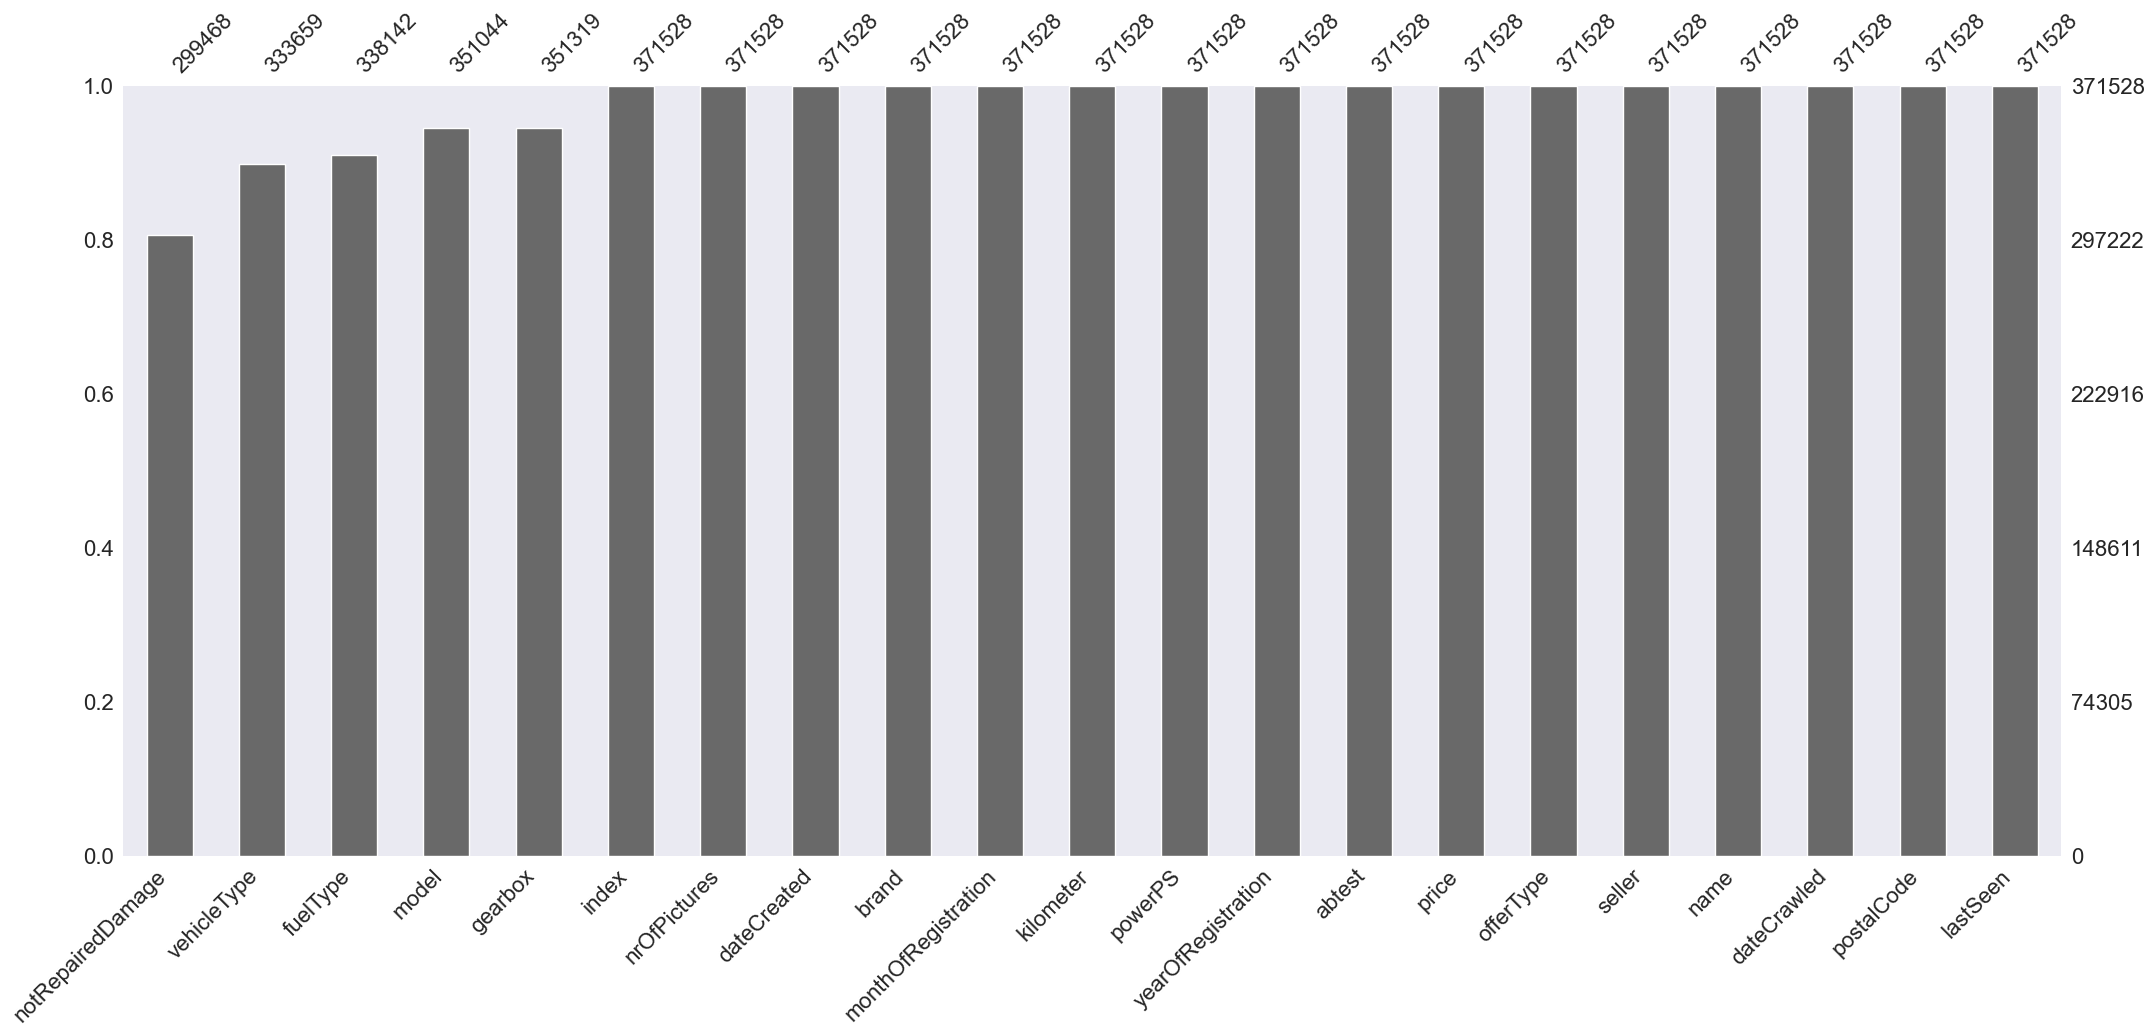

In [6]:
msno.bar(df, sort='ascending')

In [7]:
ydata_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Missing Values:

- vehicleType has 37869 (10.2%) missing values
- gearbox has 20209 (5.4%) missing values
- model has 20484 (5.5%) missing values
- fuelType has 33386 (9.0%) missing values
- notRepairedDamage has 72060 (19.4%) missing values
### DateTime
- Dtype of dateCrawled. lastSeen, and dateCreated columns is object --> Convert to DateTime
### Zeros

- price has 10778 (2.9%) zeros
- powerPS has 40820 (11.0%) zeros
- monthOfRegistration has 37675 (10.1%) zeros
### High Correlation

- price is highly overall correlated with yearOfRegistration and 1 other field
- yearOfRegistrationis highly overall correlated with price and 1 other field
- powerPS is highly overall correlated with price High correlation
- vehicleType is highly overall correlated with yearOfRegistration
### Other (Possible) Problems

- German categorical values --> English
- nrOfPictures is irrelevant --> Drop
- I think dateCrawled and dateCreated columns are the same (time doesn't matter here). These two, plus maybe even the dateCreated column are irrelevant
- I don't know how I feel about the abtest column! is it also irrelevant?

<AxesSubplot:title={'center':'Test Type'}>

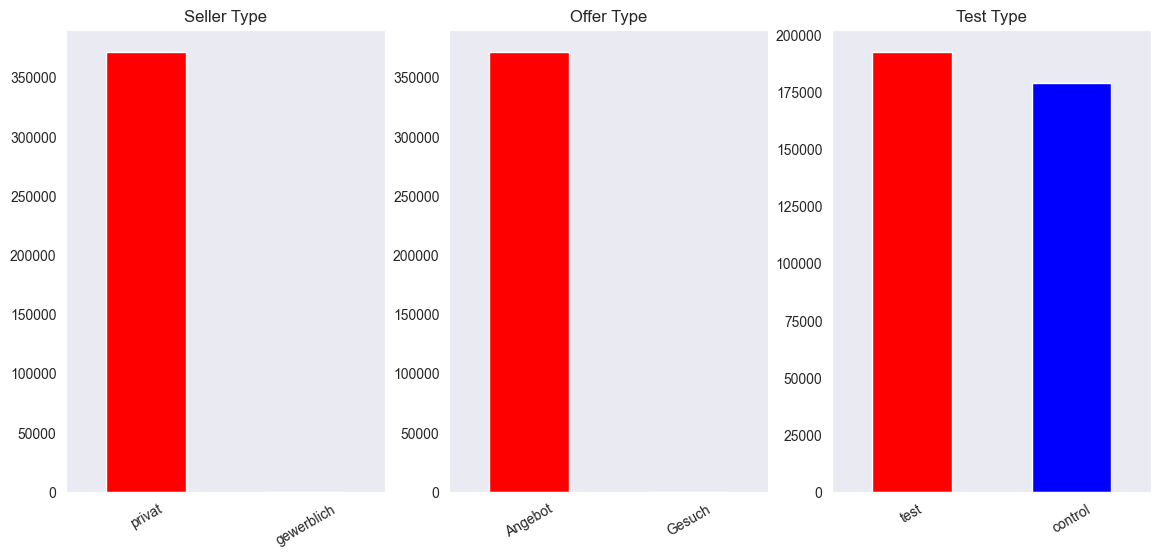

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))

df['seller'].value_counts().plot(kind='bar', title='Seller Type',  color=['red', 'blue'], ax=axes[0], rot=30, xlabel='')

df['offerType'].value_counts().plot(kind='bar', title='Offer Type',  color=['red', 'blue'], ax=axes[1], rot=30, xlabel='')

df['abtest'].value_counts().plot(kind='bar', title='Test Type',  color=['red', 'blue'], ax=axes[2], rot=30, xlabel='')

## Data Preprocessing - Part 1
- I'm also gonna drop the seller column. It's basically useless.
- As shown, the offerTyple column is also useless so I'm gonna drop this one, too.
- Also, I noticed that the yearOfRegistration column has some odd and extreme values. So, I'm gonna define a solid range for this field. I think a range between 1980 and 2023 is decent.
#### German to English:
* manuell --> Manual
* automatik --> Automatic
* ja --> Yes
* nein --> No
* benzin --> Petrol
* andere --> Other

In [9]:
# 1. DateTime Conversion --> Drop 'dateCrawled' and 'lastSeen'
df.drop(['lastSeen', 'dateCrawled'], axis=1, inplace=True)
df['dateCreated'] = pd.to_datetime(df['dateCreated'])

# 2. Drop the 'nrOfPictures', 'seller', 'offerType' columns
df.drop('nrOfPictures', axis=1, inplace=True)
df.drop('seller', axis=1, inplace=True)
df.drop('offerType', axis=1, inplace=True)

# 3. Define a range for the 'yearOfRegistration'
df = df[df['yearOfRegistration'].between(1980, 2023)]

# 4. German to English, as best as I can
df['gearbox'] = df['gearbox'].apply(lambda g: 'Manual' if g == 'manuell' else 'Automatic')
df['notRepairedDamage'] = df['notRepairedDamage'].apply(lambda g: 'Yes' if g == 'ja' else 'No' if g =='nein' else 'NaN')
df.loc[df['fuelType'] == 'benzin', 'fuelType'] = 'Petrol'
df.loc[df['fuelType'] == 'andere', 'fuelType'] = 'Other'

df.head()

df_index                            name  price abtest vehicleType   
0         0                      Golf_3_1.6    480   test         NaN  \
1         1            A5_Sportback_2.7_Tdi  18300   test       coupe   
2         2  Jeep_Grand_Cherokee_"Overland"   9800   test         suv   
3         3              GOLF_4_1_4__3TÜRER   1500   test  kleinwagen   
4         4  Skoda_Fabia_1.4_TDI_PD_Classic   3600   test  kleinwagen   

   yearOfRegistration    gearbox  powerPS  model  kilometer   
0                1993     Manual        0   golf     150000  \
1                2011     Manual      190    NaN     125000   
2                2004  Automatic      163  grand     125000   
3                2001     Manual       75   golf     150000   
4                2008     Manual       69  fabia      90000   

   monthOfRegistration fuelType       brand notRepairedDamage dateCreated   
0                    0   Petrol  volkswagen               NaN  2016-03-24  \
1                    5   diesel        audi               Yes  2016-03-24   
2                    8   diesel        jeep               NaN  2016-03-14   
3                    6   Petrol  volkswagen                No  2016-03-17   
4                    7   diesel       skoda                No  2016-03-31   

   postalCode  
0       70435  
1       66954  
2       90480  
3       91074  
4       60437

In [10]:
colors_10_1 = sns.color_palette("Spectral", 10)
colors_10_2 = sns.color_palette("Set3", 10)
colors_5 = sns.color_palette('Accent', 5)

<AxesSubplot:title={'center':'Bottom 10 Brands - Ads Count'}, xlabel='Brand', ylabel='Count'>

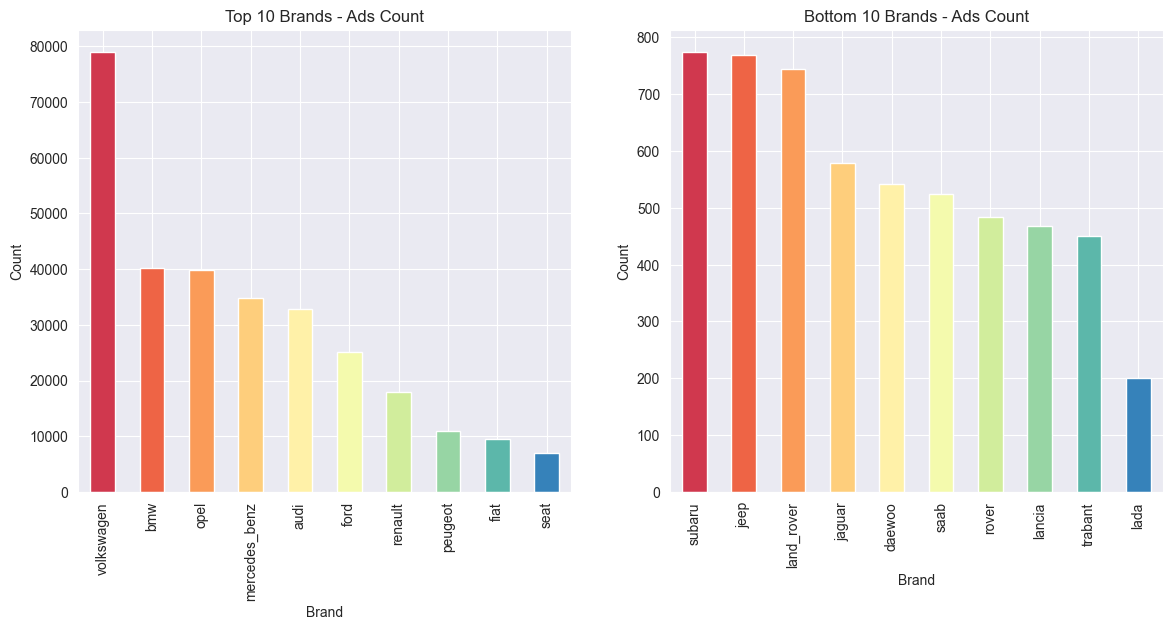

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

df['brand'].value_counts().head(10).plot(kind='bar', title='Top 10 Brands - Ads Count', color=colors_10_1, ax=axes[0], xlabel='Brand', ylabel='Count', grid=True)
df['brand'].value_counts().tail(10).plot(kind='bar', title='Bottom 10 Brands - Ads Count', color=colors_10_1, ax=axes[1], xlabel='Brand', ylabel='Count', grid=True)

<AxesSubplot:title={'center':'Bottom 10 Models by Brand - Ads Count'}, xlabel='(Brand, Model) Pairs', ylabel='Count'>

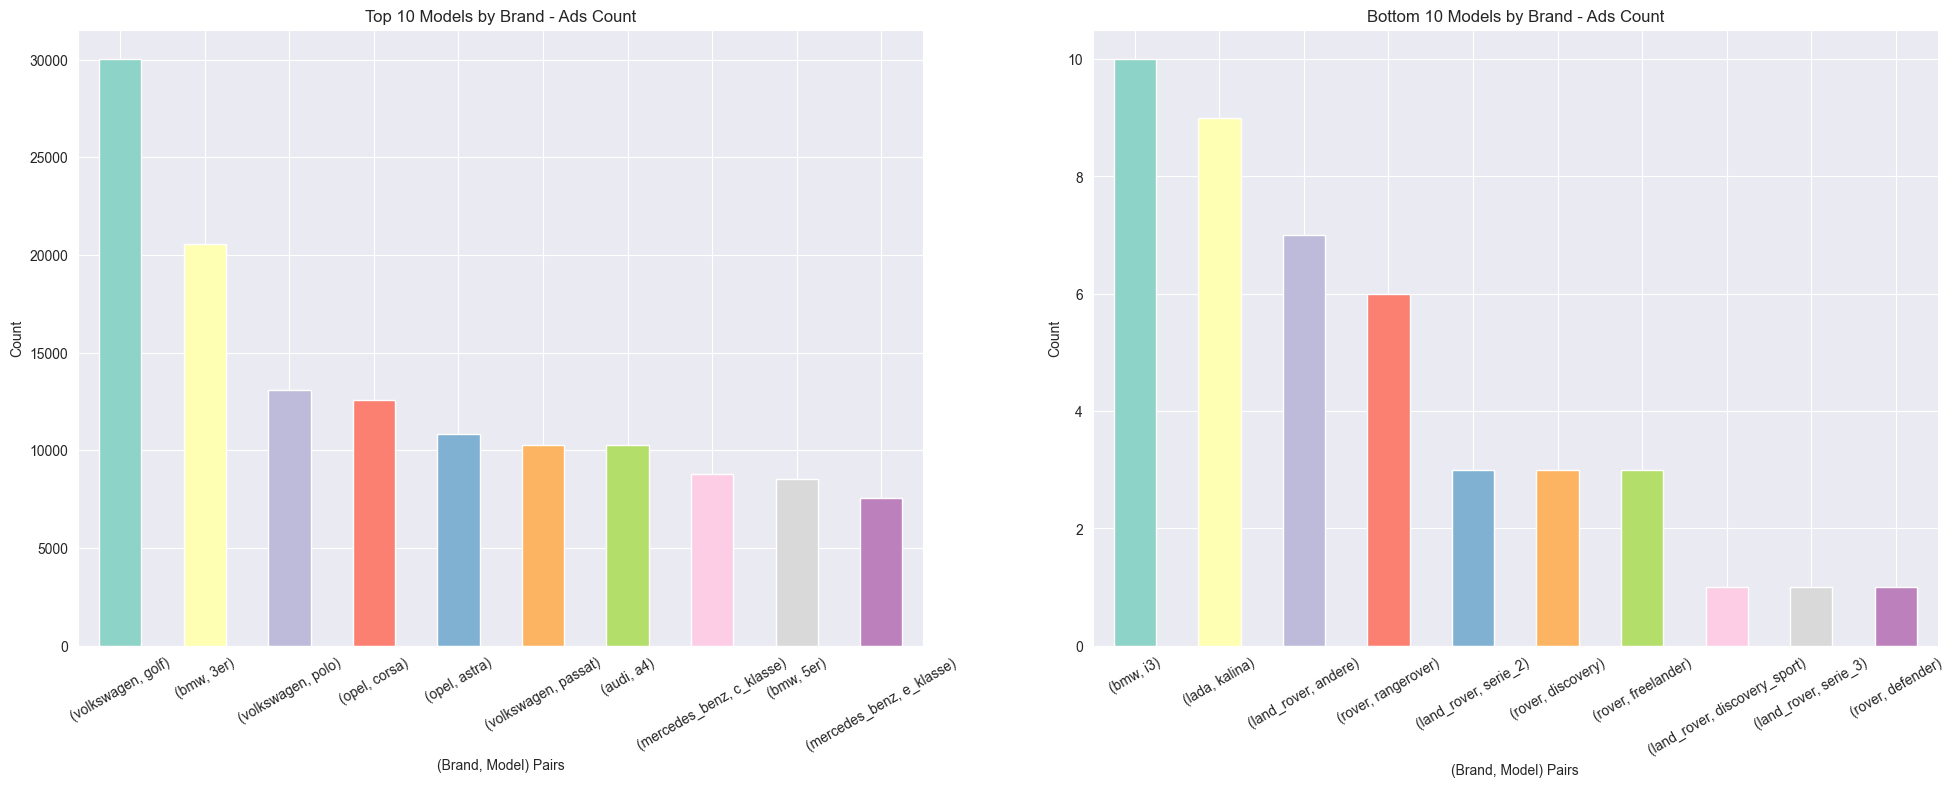

In [12]:
group_by_brand = df.groupby('brand')['model'].value_counts().sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

group_by_brand.head(10).plot(kind='bar', grid=True, rot=30, xlabel="(Brand, Model) Pairs", ylabel='Count', title='Top 10 Models by Brand - Ads Count', ax=axes[0], color=colors_10_2)
group_by_brand.tail(10).plot(kind='bar', grid=True, rot=30, xlabel="(Brand, Model) Pairs", ylabel='Count', title='Bottom 10 Models by Brand - Ads Count', ax=axes[1], color=colors_10_2)

<AxesSubplot:title={'center':'Top 10 Cars by Vehicle Type, Brand, and Model - Ads Count'}, xlabel='vehicleType,model,brand'>

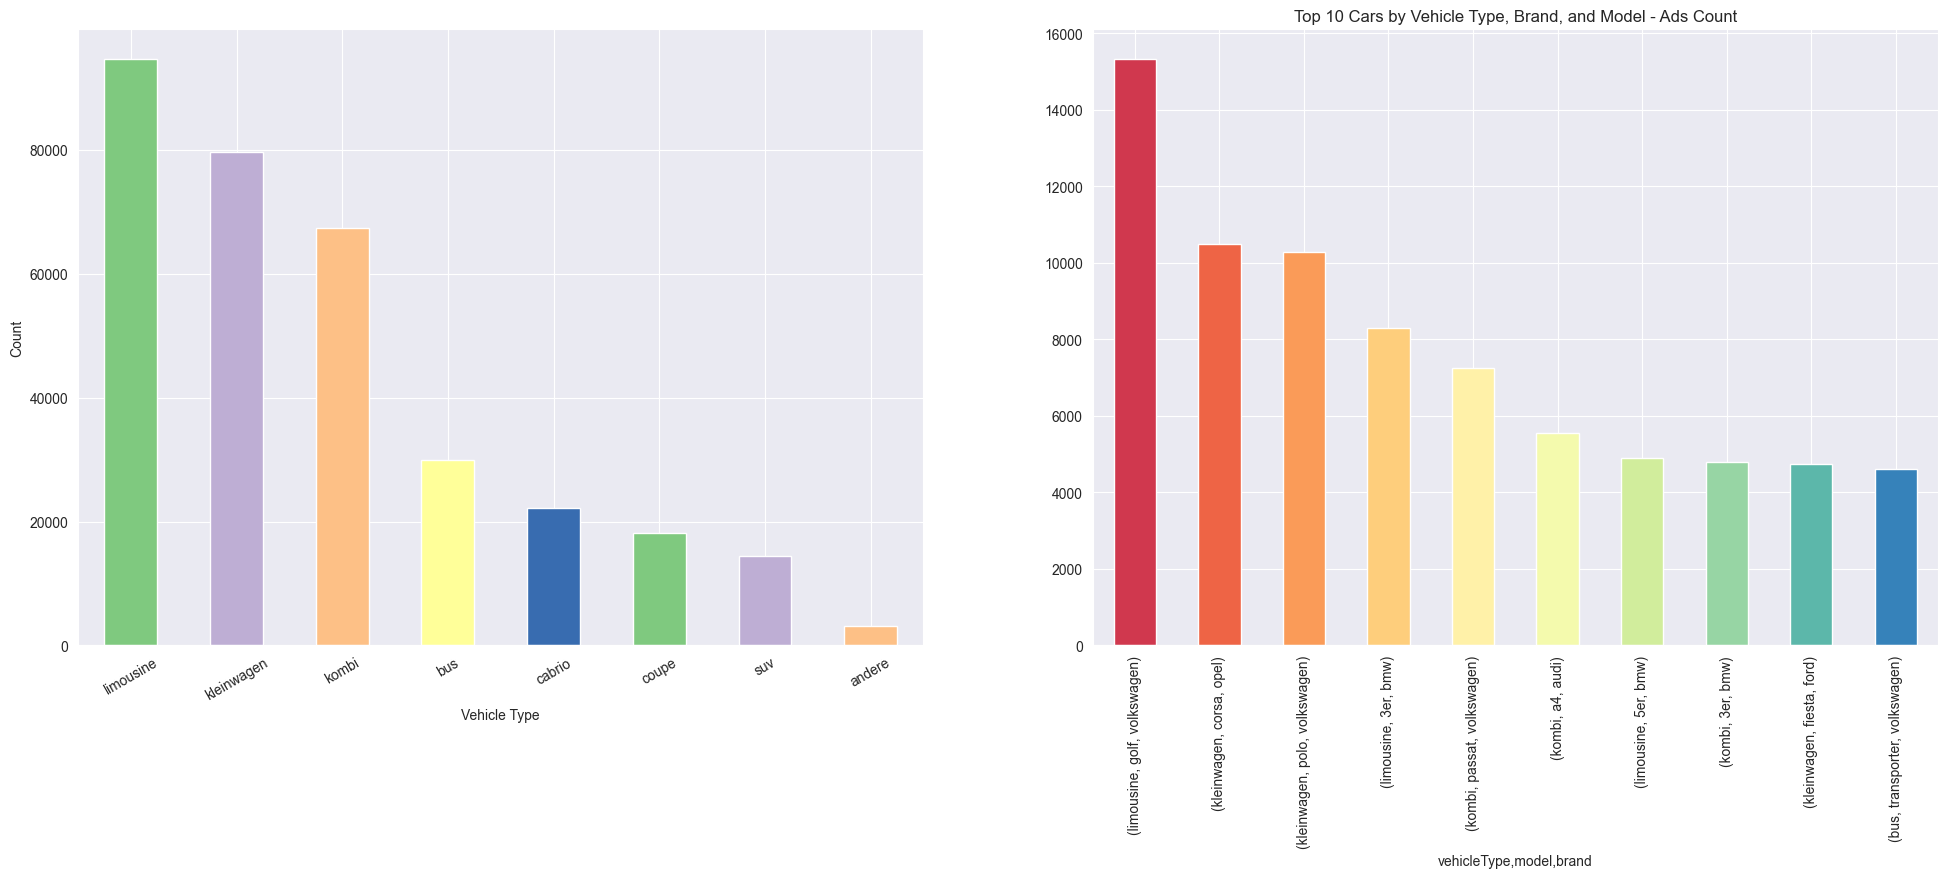

In [13]:
group_by_vehicle_type = df.groupby('vehicleType')[['model', 'brand']].value_counts().sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

df['vehicleType'].value_counts().plot(kind='bar', color=colors_5, ax=axes[0], grid=True, rot=30, xlabel='Vehicle Type', ylabel='Count', title='')
group_by_vehicle_type.head(10).plot(kind='bar', grid=True, color=colors_10_1, ax=axes[1], title='Top 10 Cars by Vehicle Type, Brand, and Model - Ads Count')

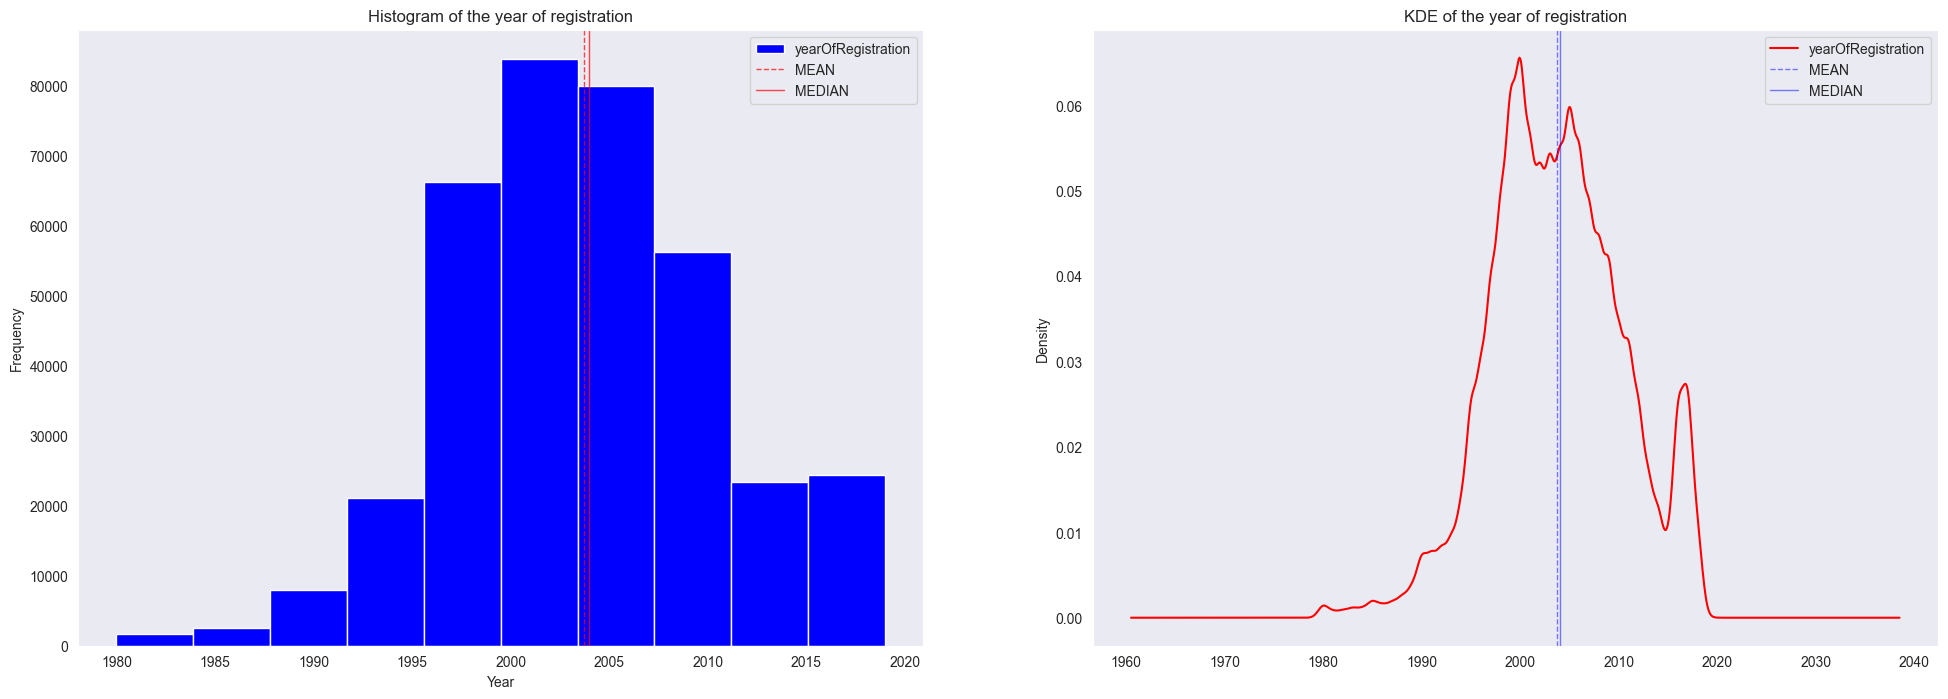

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

yr_mean = df['yearOfRegistration'].mean()
yr_median = df['yearOfRegistration'].median()

df['yearOfRegistration'].plot(kind='hist', bins=10, ax=axes[0], title='Histogram of the year of registration', xlabel='Year', color='blue')
axes[0].axvline(yr_mean, color='red', linestyle='dashed', linewidth=1, label='MEAN', alpha=.7)
axes[0].axvline(yr_median, color='red', linestyle='solid', linewidth=1, label='MEDIAN', alpha=.7)
axes[0].legend()

df['yearOfRegistration'].plot(kind='kde', ax=axes[1], title='KDE of the year of registration', xlabel='Year',  color='red')
axes[1].axvline(yr_mean, color='blue', linestyle='dashed', linewidth=1, label='MEAN', alpha=.5)
axes[1].axvline(yr_median, color='blue', linestyle='solid', linewidth=1, label='MEDIAN', alpha=.5)
axes[1].legend()

I think there's also smth wrong with the kilometer field. As illustrated, the distribution is centered around 150K. Also, there are no values higher than this. Plus, I think the values are not variable. Either way, I will leave this field alone and just use it as is.
Min. of Kilometer: 5,000 -- Max. of Kilometer: 150,000

Min. of Kilometer: 5000 -- Max. of Kilometer: 150000



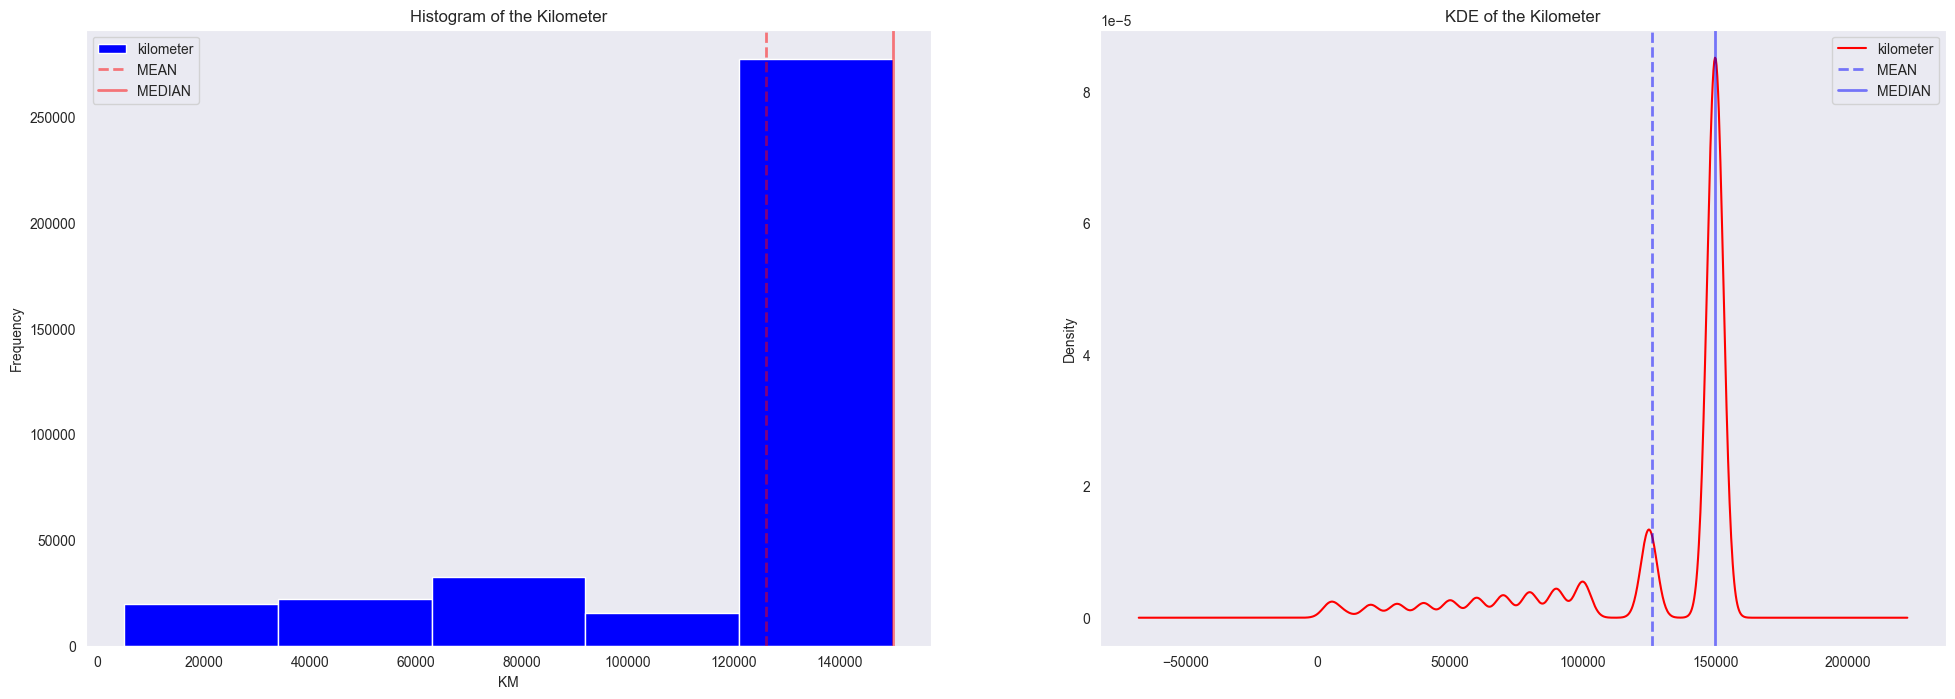

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

km_mean = df['kilometer'].mean()
km_median = df['kilometer'].median()

df['kilometer'].plot(kind='hist', bins= 5, ax=axes[0], title='Histogram of the Kilometer', xlabel='KM', color='blue')
axes[0].axvline(km_mean, color='red', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[0].axvline(km_median, color='red', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[0].legend()

df['kilometer'].plot(kind='kde', ax=axes[1], title='KDE of the Kilometer', xlabel='KM',  color='red')
axes[1].axvline(km_mean, color='blue', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[1].axvline(km_median, color='blue', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[1].legend()

print(f"Min. of Kilometer: {df['kilometer'].min()} -- Max. of Kilometer: {df['kilometer'].max()}\n")

I think I should drop rows with the fuel types of lpg, cng, hybrid, other and elektro.

<AxesSubplot:title={'center':'Repaired/Damaged?'}, xlabel='Repaired/Damaged', ylabel='Count'>

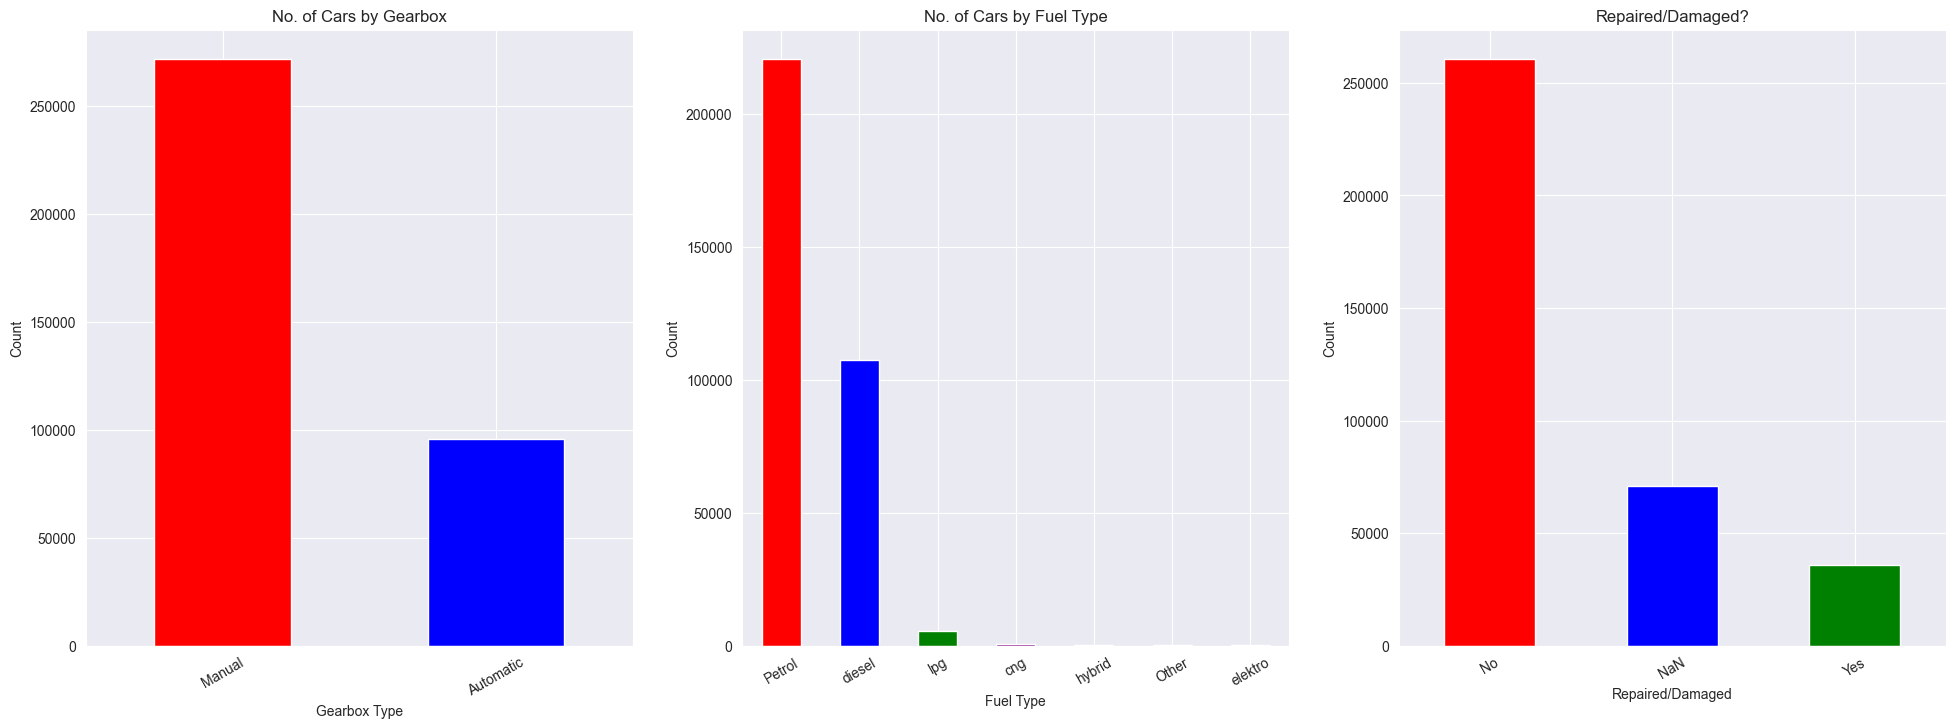

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))

df['gearbox'].value_counts().plot(kind='bar', ax=axes[0], color=['red', 'blue'], title='No. of Cars by Gearbox', xlabel='Gearbox Type', ylabel='Count', rot=30, grid=True)
df['fuelType'].value_counts().plot(kind='bar', ax=axes[1], color=['red', 'blue', 'green', 'purple'], title='No. of Cars by Fuel Type', xlabel='Fuel Type', ylabel='Count', rot=30, grid=True)
df['notRepairedDamage'].value_counts().plot(kind='bar', ax=axes[2], color=['red', 'blue', 'green'], title='Repaired/Damaged?', xlabel='Repaired/Damaged', ylabel='Count', rot=30, grid=True)

<AxesSubplot:title={'center':'KDE of the month of registration'}, ylabel='Density'>

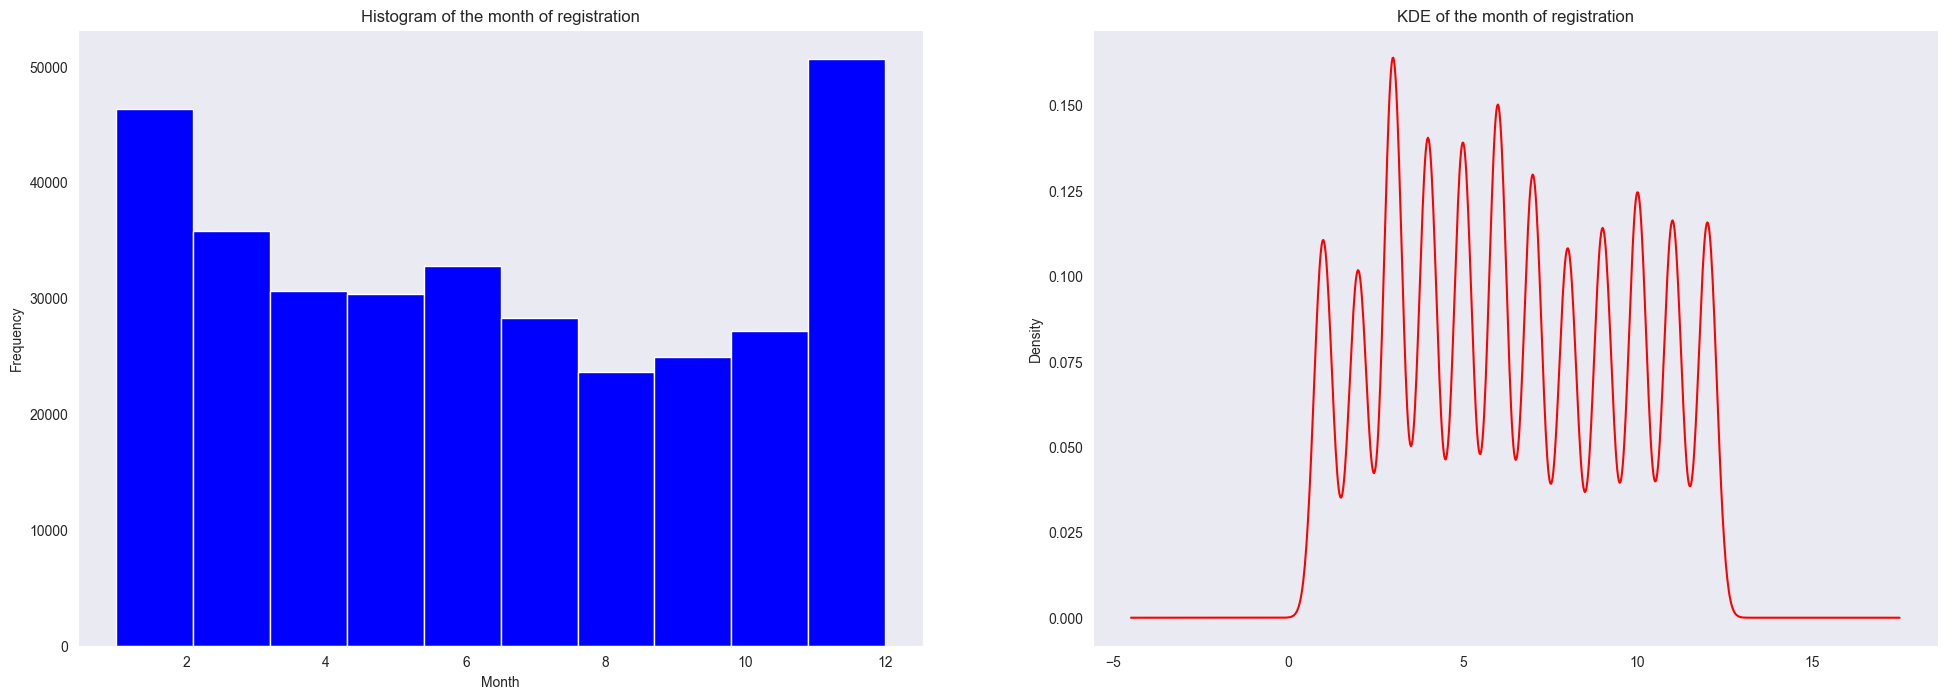

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

months = df[df['monthOfRegistration'] > 0]

months['monthOfRegistration'].plot(kind='hist', ax=axes[0], title='Histogram of the month of registration', xlabel='Month', color='blue')

months['monthOfRegistration'].plot(kind='kde', ax=axes[1], title='KDE of the month of registration', xlabel='Month', color='red')

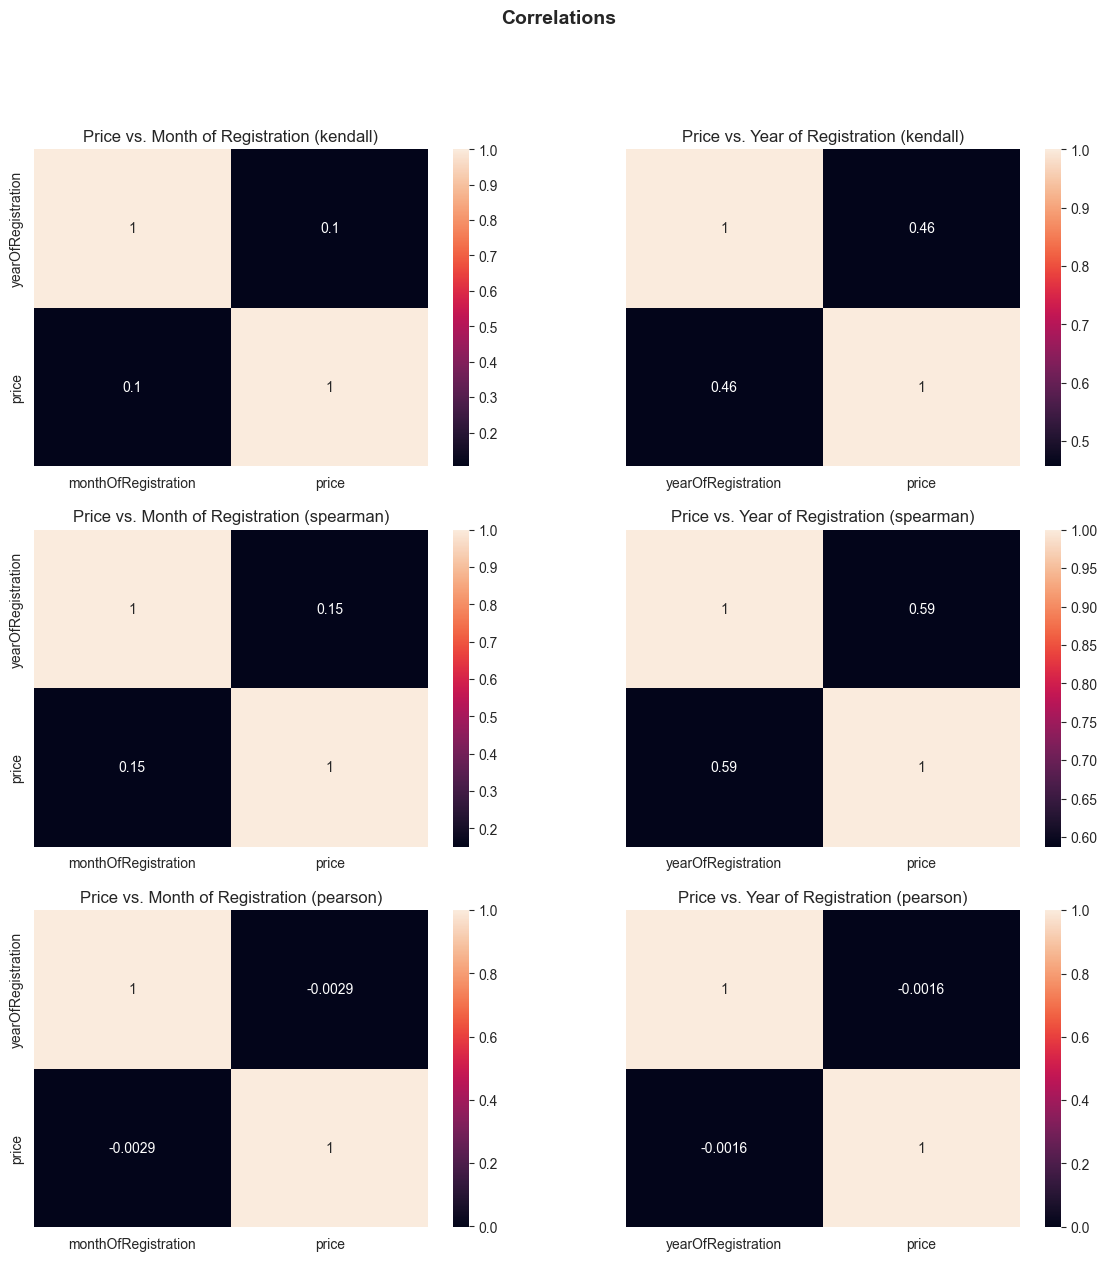

In [18]:
a = df[['monthOfRegistration', 'price']]
b = df[['yearOfRegistration', 'price']]
methods = ['kendall', 'spearman', 'pearson']

fig, axes = plt.subplots(3, 2, figsize=(14, 14), sharey=True)
fig.suptitle('Correlations', fontweight='bold', fontsize='14')

for i in range(3):
        
    sns.heatmap(a.corr(method=methods[i]), annot=True, ax=axes[i,0])
    axes[i,0].set_title(f"Price vs. Month of Registration ({methods[i]})")

    sns.heatmap(b.corr(method=methods[i]), annot=True, ax=axes[i,1])
    axes[i,1].set_title(f"Price vs. Year of Registration ({methods[i]})")

There's no correlation between Price and Month of registration, so I'm gonna drop it later.

The range of the price

In [19]:
print(f"No. of cars with a price value higher than 20K: {Style.BRIGHT}{len(df[df['price'] > 20_000])}")
print(f"{Style.RESET_ALL}No. of cars with a price value higher than 30K: {Style.BRIGHT}{len(df[df['price'] > 30_000])}")
print(f"{Style.RESET_ALL}No. of cars with a price value higher than 40K: {Style.BRIGHT}{len(df[df['price'] > 40_000])}")
print(f"{Style.RESET_ALL}Mean of price: {Style.BRIGHT}{df['price'].mean():.2f}{Style.RESET_ALL}, Median of price: {Style.BRIGHT}{df['price'].median()}")
print(f"{Style.RESET_ALL}Min. price: {Style.BRIGHT}{df['price'].min()}{Style.RESET_ALL}, Max. price: {Style.BRIGHT}{df['price'].max()}")

No. of cars with a price value higher than 20K: 16469
No. of cars with a price value higher than 30K: 5556
No. of cars with a price value higher than 40K: 2501
Mean of price: 16611.71, Median of price: 2944.0
Min. price: 0, Max. price: 2147483647


As shown, the range of [200, 20K] is better than the other two and it eliminates a largre proportion of outliers. We can go even lower, but I don't like doing so. Just remember that the prices are skewed.

In [20]:
df['price'].quantile(.95), df['price'].quantile(.05)

(19500.0, 200.0)

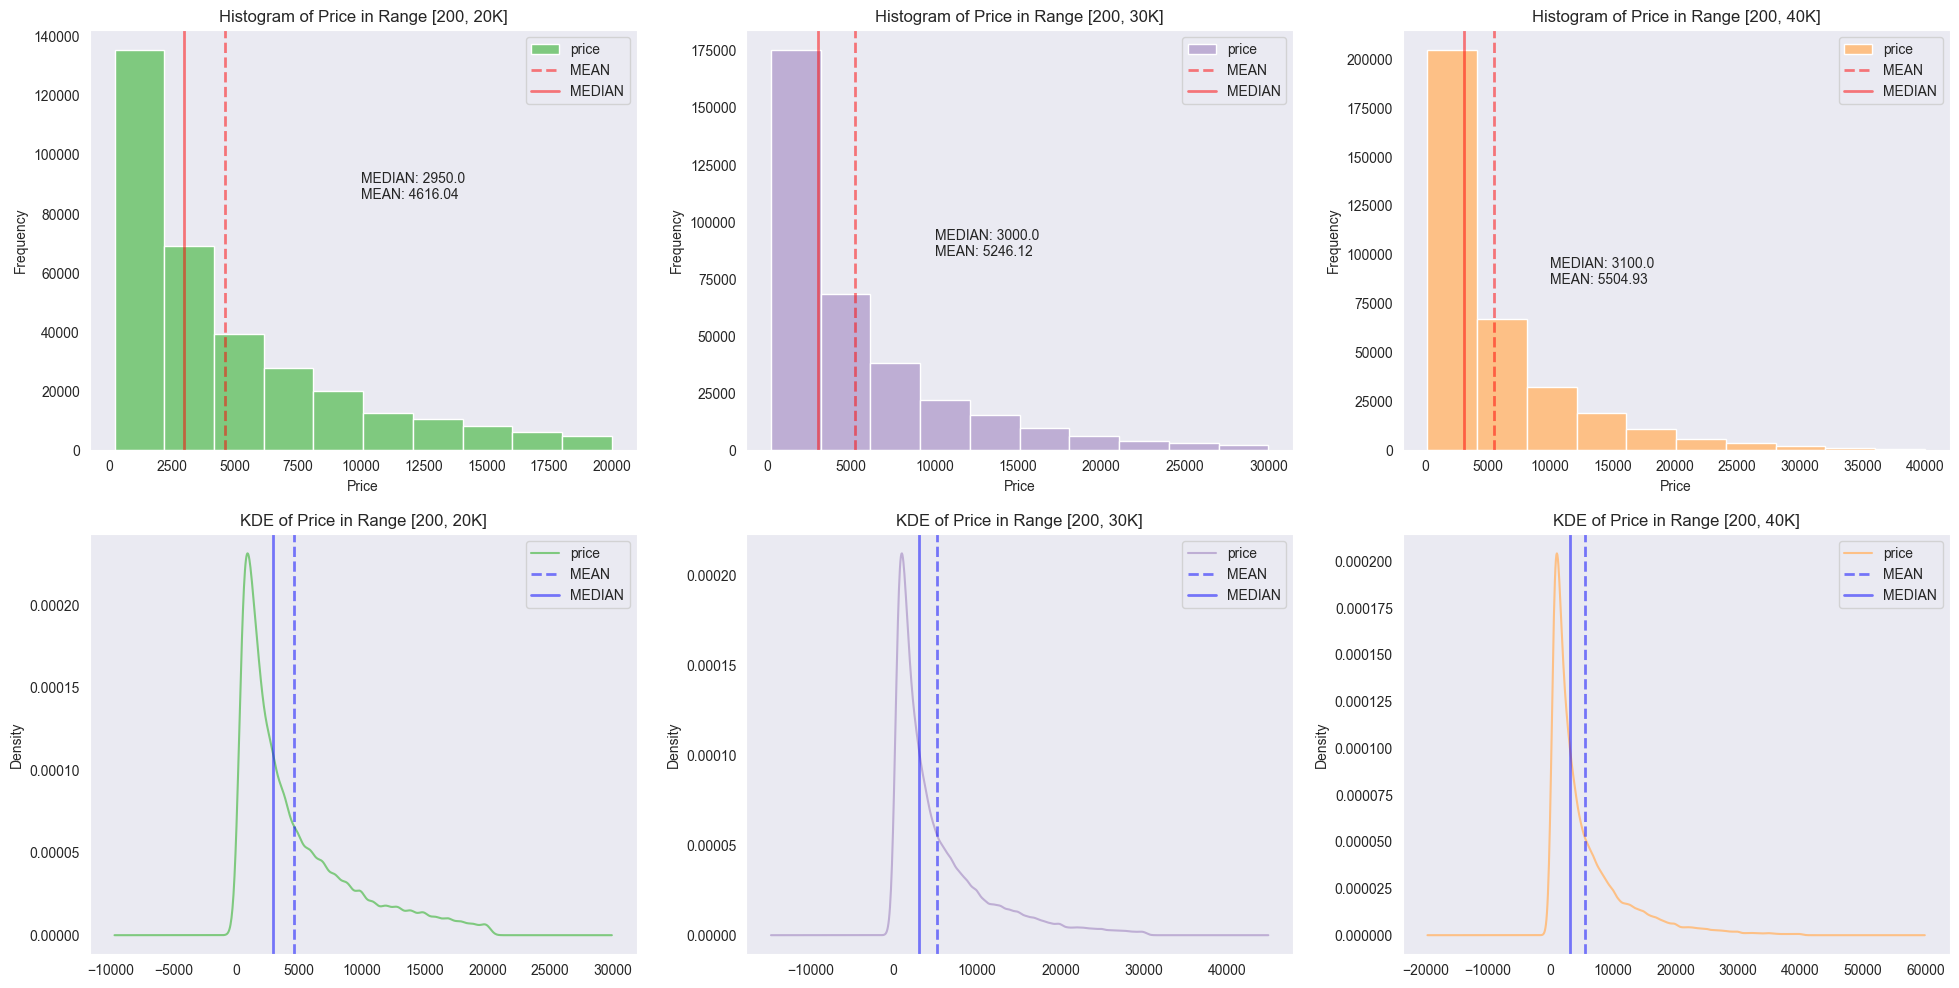

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))

bins = 10

price_20 = df.loc[df['price'].between(200, 20_000), 'price']
price_30 = df.loc[df['price'].between(200, 30_000), 'price']
price_40 = df.loc[df['price'].between(200, 40_000), 'price']

price_20.plot(kind='hist', bins=bins, ax=axes[0,0], title='Histogram of Price in Range [200, 20K]', xlabel='Price', color=colors_5[0])
axes[0,0].axvline(price_20.mean(), color='red', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[0,0].axvline(price_20.median(), color='red', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[0,0].legend()
txt = f'MEDIAN: {price_20.median()}\nMEAN: {price_20.mean():.2f}'
axes[0,0].text(10_000, 85_000, txt)

price_30.plot(kind='hist', bins=bins, ax=axes[0,1], title='Histogram of Price in Range [200, 30K]', xlabel='Price', color=colors_5[1])
axes[0,1].axvline(price_30.mean(), color='red', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[0,1].axvline(price_30.median(), color='red', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[0,1].legend()
txt = f'MEDIAN: {price_30.median()}\nMEAN: {price_30.mean():.2f}'
axes[0,1].text(10_000, 85_000, txt)

price_40.plot(kind='hist', bins=bins, ax=axes[0,2], title='Histogram of Price in Range [200, 40K]', xlabel='Price', color=colors_5[2])
axes[0,2].axvline(price_40.mean(), color='red', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[0,2].axvline(price_40.median(), color='red', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[0,2].legend()
txt = f'MEDIAN: {price_40.median()}\nMEAN: {price_40.mean():.2f}'
axes[0,2].text(10_000, 85_000, txt)

price_20.plot(kind='kde', ax=axes[1,0], title='KDE of Price in Range [200, 20K]', xlabel='Price',  color=colors_5[0])
axes[1,0].axvline(price_20.mean(), color='blue', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[1,0].axvline(price_20.median(), color='blue', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[1,0].legend()

price_30.plot(kind='kde', ax=axes[1,1], title='KDE of Price in Range [200, 30K]', xlabel='Price',  color=colors_5[1])
axes[1,1].axvline(price_30.mean(), color='blue', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[1,1].axvline(price_30.median(), color='blue', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[1,1].legend()

price_40.plot(kind='kde', ax=axes[1,2], title='KDE of Price in Range [200, 40K]', xlabel='Price',  color=colors_5[2])
axes[1,2].axvline(price_40.mean(), color='blue', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[1,2].axvline(price_40.median(), color='blue', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[1,2].legend()

# Data Preprocessing - Part 2

* Drop null values
* As mentioned above, the range of price will be set to[200, 20K]
* Drop the extreme values of the powerPS
* Drop the postalCode, dateCreated, name, and monthOfRegistration columns
* Add a new column for the age of the car. Then drop the yearOfRegistration column
* Convert categorical values to numerical (using LabelEncoder)

In [22]:
# drop null values
df.dropna(inplace=True)

# Drop cars with unacceptable prices
df = df[df['price'].between(200, 20_000)]

# Drop cars with extreme powerPS
df = df[(df['powerPS'] > 0) & (df['powerPS'] <= 1000)]

# Add the 'age' column
current_year = 2023
df['age'] = current_year - df['yearOfRegistration']

# Drop unnecessary columns and rows
df.drop(['postalCode', 'dateCreated', 'name', 'monthOfRegistration', 'yearOfRegistration'], axis=1, inplace=True)
df = df[df['fuelType'] != 'Other']
df = df[df['notRepairedDamage'] != 'NaN']

# Categorical to Numerical
categorical_features = ['vehicleType', 'fuelType', 'brand', 'model', 'abtest', 'notRepairedDamage', 'gearbox']
le = LabelEncoder()

for categorical_feature in categorical_features:
    df[categorical_feature] = le.fit_transform(df[categorical_feature])

In [72]:
df = df.drop('df_index', axis=1)

In [73]:
df.head()

price  abtest  vehicleType  gearbox  powerPS  model  kilometer  fuelType   
3    1500       1            4        1       75    117     150000         0  \
4    3600       1            4        1       69    102      90000         2   
5     650       1            6        1      102     11     150000         0   
6    2200       1            2        1      109      8     150000         0   
10   2000       0            6        1      105     10     150000         0   

    brand  notRepairedDamage  age  
3      37                  0   22  
4      31                  0   15  
5       2                  1   28  
6      25                  0   19  
10     19                  0   19

Now let's look at the correlations one more time, since I'm a bit skeptical about the brand.
I'm also going to define a range of [0.2, -0.2] for the correlation values.

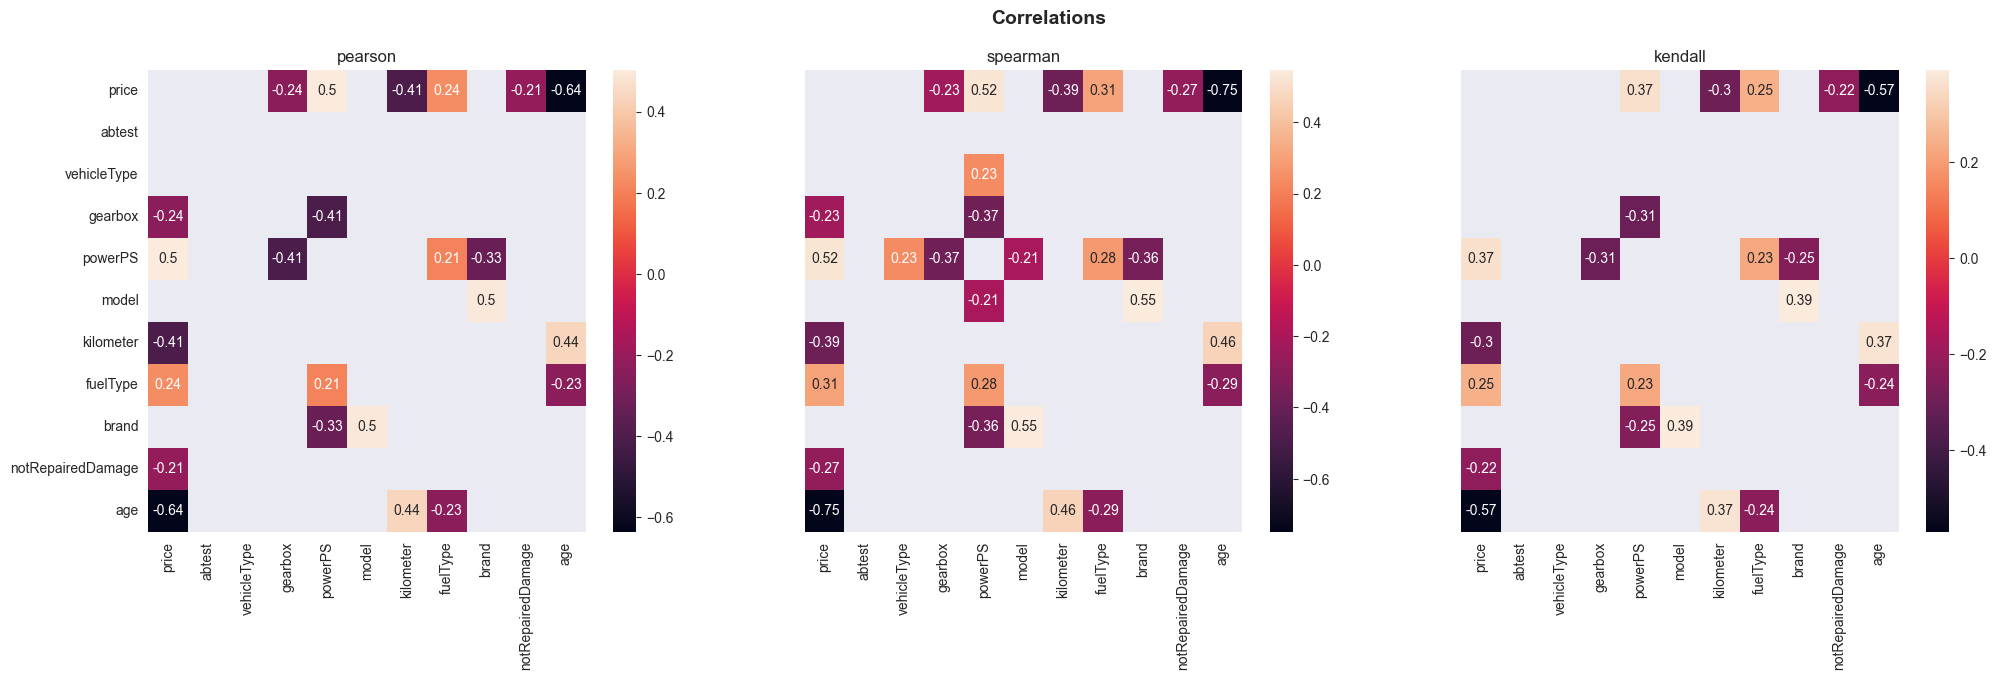

In [74]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
fig.suptitle('Correlations', fontweight='bold', fontsize='14')
methods = ['pearson', 'spearman', 'kendall']

for i in range(3):
    corr = df.corr(method=methods[i])
    corr = corr[((corr >= 0.2) | (corr <= -0.2)) & (corr != 1)]
    sns.heatmap(corr, annot=True, ax=axes[i])
    axes[i].set_title(f"{methods[i]}")

 I think the data itself is quite ready for this phase. However, I should apply Feature Scaling with Z-Score Norm. I will also split the data with a ratio of %70, %15, and %15.

In [75]:
features = df.drop(['price'], axis=1)
target = df['price']

scaler = StandardScaler()
numerical_features = ['kilometer', 'powerPS', 'age']
features[numerical_features] = scaler.fit_transform(features[numerical_features])

In [97]:
features.head()

abtest  vehicleType  gearbox   powerPS  model  kilometer  fuelType  brand   
3        1            4        1 -0.894859    117   0.619715         0     37  \
4        1            4        1 -1.006160    102  -1.004467         2     31   
5        1            6        1 -0.394002     11   0.619715         0      2   
6        1            2        1 -0.264151      8   0.619715         0     25   
10       0            6        1 -0.338352     10   0.619715         0     19   

    notRepairedDamage       age  
3                   0  0.415609  
4                   0 -0.842632  
5                   1  1.494102  
6                   0 -0.123637  
10                  0 -0.123637

In [113]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=666, train_size=0.85)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=666, train_size=0.8235)

In [114]:
print(f'{Fore.BLUE}X_train Shape: {Fore.GREEN}{X_train.shape}')
print(f'{Fore.BLUE}y_train Shape: {Fore.GREEN}{y_train.shape}')

print(f'{Fore.RED}{Back.LIGHTYELLOW_EX}--'*13)

print(f'{Back.RESET}{Fore.BLUE}X_test Shape: {Fore.GREEN}{X_test.shape}')
print(f'{Fore.BLUE}y_test Shape: {Fore.GREEN}{y_test.shape}')

print(f'{Fore.RED}{Back.LIGHTYELLOW_EX}--'*13)

print(f'{Back.RESET}{Fore.BLUE}X_val Shape:  {Fore.GREEN}{X_val.shape}')
print(f'{Fore.BLUE}y_val Shape:  {Fore.GREEN}{y_val.shape}')

X_train Shape: (162568, 10)
y_train Shape: (162568,)
--------------------------
X_test Shape: (34838, 10)
y_test Shape: (34838,)
--------------------------
X_val Shape:  (34844, 10)
y_val Shape:  (34844,)


# Modeling 
In this phase, I'm going to train different models in order to predict the price of a used car based on other features (10 in total). I plan to use:
- A Deep Neural Network
- Conventional ML methods for regression
- Ensembling
- XAI using SHAP

## 1)- Deep Neural Network
- A DNN with the following number of neurons: 32, 64, 128
- Dropout with a probability of 0.2
- ReLU activiation function for the hidden layers
- A Linear activation function for the output layer
- Loss: MSE, Metric: MAE
- Adam optimizer with the default learning rate
- Epoch: 50, Batch Size: 512
- EarlyStopping with a focus on the val_loss
- Saving checkpoints based on the validation MAE
- A Learning Rate Scheduler (Visualized further down)

In [100]:
epoch = 50
batch_size = 512
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('./best_model.h5', monitor='val_mean_absolute_error', mode='min', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

In [101]:
model = Sequential()

model.add(Dense(32, input_dim=X_train.shape[1], activation='relu', name='Dense_1'))
model.add(Dropout(0.2, name='Dropout_1'))

model.add(Dense(64, 'relu', name='Dense_2'))
model.add(Dropout(0.2, name='Dropout_2'))

model.add(Dense(128, 'relu', name='Dense_3'))
model.add(Dropout(0.2, name='Dropout_3'))

model.add(Dense(64, 'relu', name='Dense_4'))
model.add(Dropout(0.2, name='Dropout_4'))

model.add(Dense(32, 'relu', name='Dense_5'))

model.add(Dense(1, 'linear', name='Predictor'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_absolute_error'])

In [102]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, rankdir='LR')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [103]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size= batch_size,
                    epochs=epoch,
                    callbacks=[mc, lr_schedule, es])

Epoch 1/50
310/318 [============================>.] - ETA: 0s - loss: 27278120.0000 - mean_absolute_error: 3844.6140
Epoch 1: val_mean_absolute_error improved from inf to 2538.10669, saving model to .\best_model.h5
318/318 [==============================] - 1s 3ms/step - loss: 26972690.0000 - mean_absolute_error: 3821.3430 - val_loss: 12684515.0000 - val_mean_absolute_error: 2538.1067 - lr: 0.0010
Epoch 2/50
304/318 [===========================>..] - ETA: 0s - loss: 9724798.0000 - mean_absolute_error: 2195.9082
Epoch 2: val_mean_absolute_error improved from 2538.10669 to 1630.65088, saving model to .\best_model.h5
318/318 [==============================] - 1s 3ms/step - loss: 9637501.0000 - mean_absolute_error: 2182.0601 - val_loss: 6179064.0000 - val_mean_absolute_error: 1630.6509 - lr: 9.0484e-04
Epoch 3/50
303/318 [===========================>..] - ETA: 0s - loss: 7239491.5000 - mean_absolute_error: 1809.3347
Epoch 3: val_mean_absolute_error improved from 1630.65088 to 1554.25415, s

With an r2 score of 0.8, the DNN model did NOT perform as I was expecting

In [104]:
from keras.models import load_model

dnn_model = load_model('C:\FP-UNA\ML engineer\Project 1/best_model.h5')
dnn_eval = model.evaluate(X_test, y_test)
dnn_preds = model.predict(X_test)

print(f"{Fore.BLUE}DNN - Test set\n\nMSE: {Fore.RED}{dnn_eval[0]}\n{Fore.BLUE}MAE: {Fore.RED}{dnn_eval[1]:.2f}")
print(f"{Fore.BLUE}R2-Score: {Fore.RED}{r2_score(y_test, dnn_preds):.3f}")


1089/1089 [==============================] - 1s 458us/step
DNN - Test set

MSE: 4430520.0
MAE: 1375.10
R2-Score: 0.800


Visualizando MSE, MAE y LR

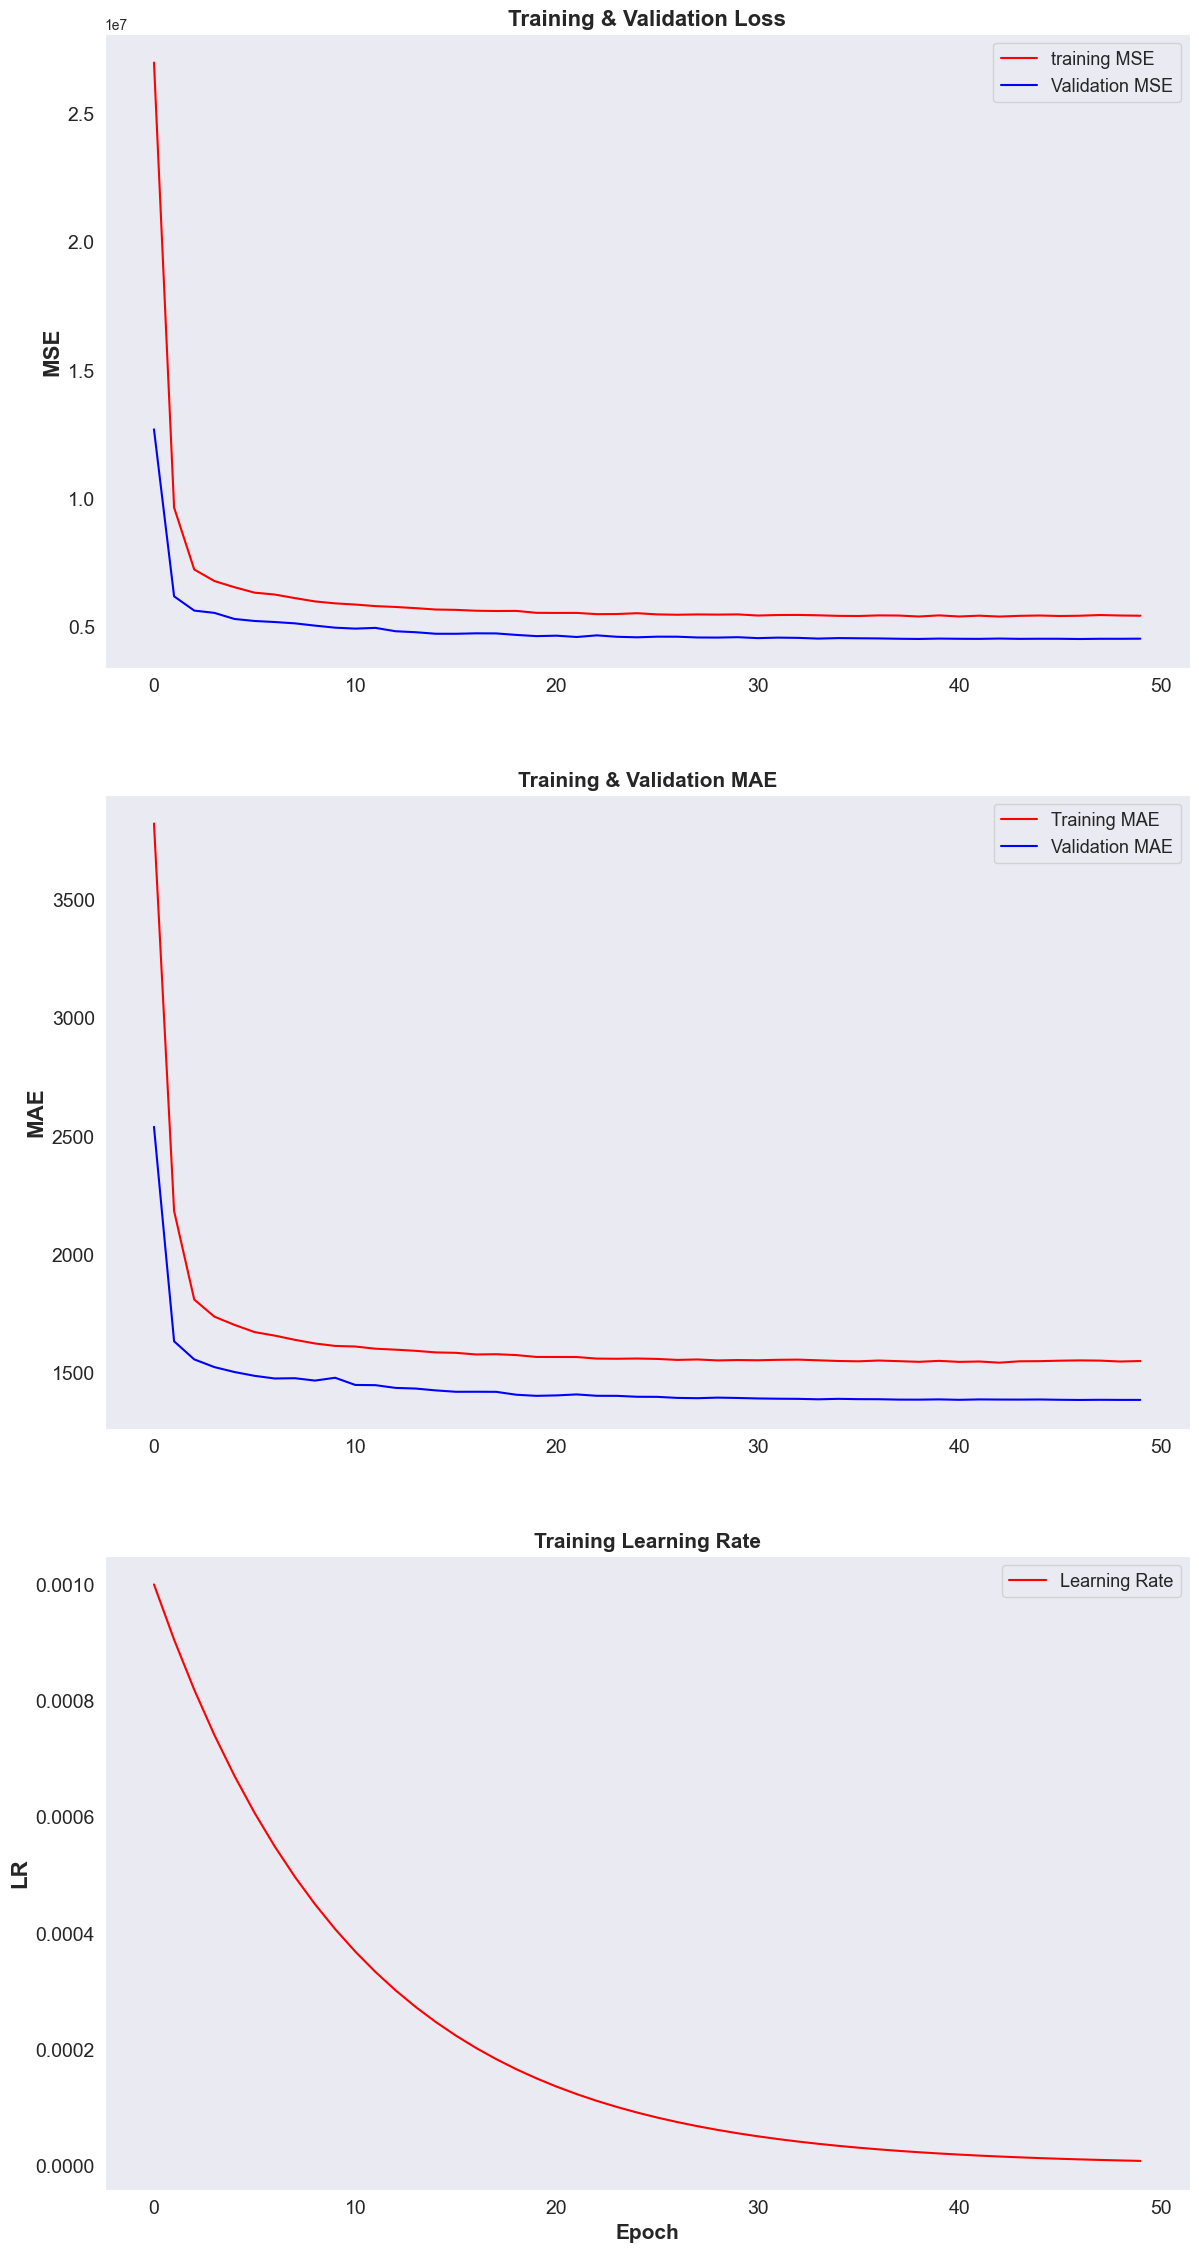

In [105]:
lr = history.history['lr']
loss = history.history['loss']
val_loss = history.history['val_loss']
t_mae = history.history['mean_absolute_error']
v_mae = history.history['val_mean_absolute_error']

plt.figure(figsize=(14, 28))

#MSE

plt.subplot(3, 1, 1)
plt.plot(loss, label= 'training MSE', color= 'r')
plt.plot(val_loss, label='Validation MSE', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('MSE', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=16, weight='bold')

# MAE
plt.subplot(3, 1, 2)
plt.plot(t_mae, label='Training MAE', color='r')
plt.plot(v_mae, label='Validation MAE', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=13)
plt.ylabel('MAE', fontsize=16, weight='bold')
plt.title('Training & Validation MAE', fontsize=15, weight='bold')

# Learning Rate
plt.subplot(3, 1, 3)
plt.plot(lr, label='Learning Rate', color='r')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('LR', fontsize=16, weight='bold')
plt.title('Training Learning Rate', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.show()

Quiero ver la diferencia entre los valores previstos y reales de algunas muestras.

In [106]:
c = 50
for _ in range(10):
    print(y_test.values[c] - dnn_preds[c])
    c += c

[-276.7152]
[-1107.7001]
[1656.0146]
[-978.49414]
[-2281.8281]
[-773.7988]
[484.7262]
[-217.3667]
[-576.7008]
[3173.4888]


# 2)- ML

* **Regresion Models:** Decision Tree, Random Forest, Extra Trees, AdaBoost, XGBoost, CatBoost, and KNeighbors
* **Metrics:** MSE, MAE, R2 Score
* Cross-validation


In [107]:
X_train, y_train, X_test, y_test = train_test_split(features.values, target.values, test_size=0.2, random_state=15)

print(f'Train shape {X_train.shape}\nTest shape: {X_test.shape}')

Train shape (185800, 10)
Test shape: (185800,)


In [108]:
scores_metric = {'R2-score': make_scorer(r2_score),
                 'MAE': make_scorer(mean_absolute_error),
                 'MSE': make_scorer(mean_squared_error)}

In [117]:
def score_vis(score):
    names = ['Decision Tree', 'Random Forest', 'Extra Trees', 'AdaBoost', 'XGBoost', 'CatBoost', 'KNN']
    
    plt.rcParams['figure.figsize']=20,8 
    ax = sns.barplot(x=names, y=score, palette='plasma', saturation=2.0)
    
    plt.xlabel('Model', fontsize = 20)
    plt.ylabel('R2-score(%)', fontsize = 20)
    plt.title('Model Performance Comparison - Test set', fontsize=20)
    plt.xticks(fontsize=12, horizontalalignment = 'center', rotation = 8)
    plt.yticks(fontsize = 12)
    
    for i in ax.patches:
        width, height = i.get_width(), i.get_height()
        x, y = i.get_xy() 
        ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize='x-large')
        
    plt.show()
    

In [110]:
def trainer(X_train, y_train, X_test, y_test):
    
    models= [['Decision Tree', DecisionTreeRegressor()],
             ['Random Forest', RandomForestRegressor(n_estimators=124)],
             ['Extra Trees', ExtraTreesRegressor(n_estimators=124)],
             ['AdaBoost', AdaBoostRegressor(loss='square', n_estimators=1000)],
             ['XGBoost', XGBRegressor(tree_method='hist', n_estimators=1000)],
             ['CatBoost', CatBoostRegressor(logging_level='Silent')],
             ['KNN', KNeighborsRegressor(weights='distance')]]

    scores = []
    
    print(Back.RED + Fore.BLACK + Style.BRIGHT + '⁜⁜ STARTING THE PROCESS... ⁜⁜\n\n')
    print(Back.RESET)
    
    for model_name, model in models:
        
        print(Fore.LIGHTRED_EX + 'Cross validating the ' + model_name + ' model...\n')
        model = model
        result = cross_validate(model, X_train, y_train, cv=5, verbose=1, scoring=scores_metric)
        
        for key, value in result.items():
            print(f"{Fore.BLUE}{key}: {Fore.RED}{np.mean(value):.3f} {Fore.BLUE}+- {Fore.RED}{np.std(value):.3f}")
        
        print(Fore.LIGHTGREEN_EX + '\nTraining...')
        model.fit(X_train, y_train)
        
        print(Fore.LIGHTGREEN_EX + 'Predicting...\n')
        pred = model.predict(X_test)
        
        scores.append(r2_score(y_test, pred))
        print(f"{Fore.BLUE}{model_name} Test R2-Score: {Fore.RED}{r2_score(y_test, pred):.3f}")
        print(f"{Fore.BLUE}{model_name} Test MAE:      {Fore.RED}{mean_absolute_error(y_test, pred):.3f}")

        print('\n' + Fore.BLACK + Back.WHITE + '⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜\n' + Back.RESET)
    
    print('\n\n\n' + Back.RED + Fore.BLACK + Style.BRIGHT + '⁜⁜ PROCESS COMPLETED! ⁜⁜')
    
    return scores

In [115]:
scores = trainer(X_train, y_train, X_test, y_test)

⁜⁜ STARTING THE PROCESS... ⁜⁜



Cross validating the Decision Tree model...



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished


fit_time: 0.421 +- 0.021
score_time: 0.015 +- 0.003
test_R2-score: 0.831 +- 0.005
test_MAE: 1164.477 +- 7.677
test_MSE: 3753934.057 +- 121467.800

Training...
Predicting...

Decision Tree Test R2-Score: 0.838
Decision Tree Test MAE:      1138.828

⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜

Cross validating the Random Forest model...



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min finished


fit_time: 32.485 +- 0.799
score_time: 1.038 +- 0.029
test_R2-score: 0.885 +- 0.002
test_MAE: 1005.089 +- 6.253
test_MSE: 2537596.422 +- 58308.465

Training...
Predicting...

Random Forest Test R2-Score: 0.890
Random Forest Test MAE:      993.263

⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜

Cross validating the Extra Trees model...



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished


fit_time: 23.435 +- 0.339
score_time: 1.116 +- 0.015
test_R2-score: 0.879 +- 0.003
test_MAE: 1028.201 +- 7.246
test_MSE: 2673968.848 +- 65253.959

Training...
Predicting...

Extra Trees Test R2-Score: 0.884
Extra Trees Test MAE:      1010.526

⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜

Cross validating the AdaBoost model...



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.6min finished


fit_time: 75.952 +- 2.076
score_time: 2.706 +- 0.042
test_R2-score: -0.896 +- 0.023
test_MAE: 5918.342 +- 17.374
test_MSE: 41990173.534 +- 227531.059

Training...
Predicting...

AdaBoost Test R2-Score: -0.920
AdaBoost Test MAE:      5952.882

⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜

Cross validating the XGBoost model...



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.9s finished


fit_time: 1.502 +- 0.039
score_time: 0.093 +- 0.001
test_R2-score: 0.896 +- 0.002
test_MAE: 956.597 +- 7.328
test_MSE: 2304461.284 +- 49143.363

Training...
Predicting...

XGBoost Test R2-Score: 0.898
XGBoost Test MAE:      953.622

⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜

Cross validating the CatBoost model...



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   41.4s finished


fit_time: 8.286 +- 0.096
score_time: 0.008 +- 0.002
test_R2-score: 0.892 +- 0.002
test_MAE: 997.040 +- 5.470
test_MSE: 2394291.412 +- 47996.078

Training...
Predicting...

CatBoost Test R2-Score: 0.891
CatBoost Test MAE:      1002.507

⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜

Cross validating the KNN model...



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.9s finished


fit_time: 0.251 +- 0.008
score_time: 1.154 +- 0.043
test_R2-score: 0.859 +- 0.004
test_MAE: 1103.265 +- 9.522
test_MSE: 3124362.388 +- 94361.376

Training...
Predicting...

KNN Test R2-Score: 0.862
KNN Test MAE:      1090.032

⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜




⁜⁜ PROCESS COMPLETED! ⁜⁜


Como se muestra, XGBoostRegressor ofreció el mejor rendimiento, mientras que AdaBoost es el peor.

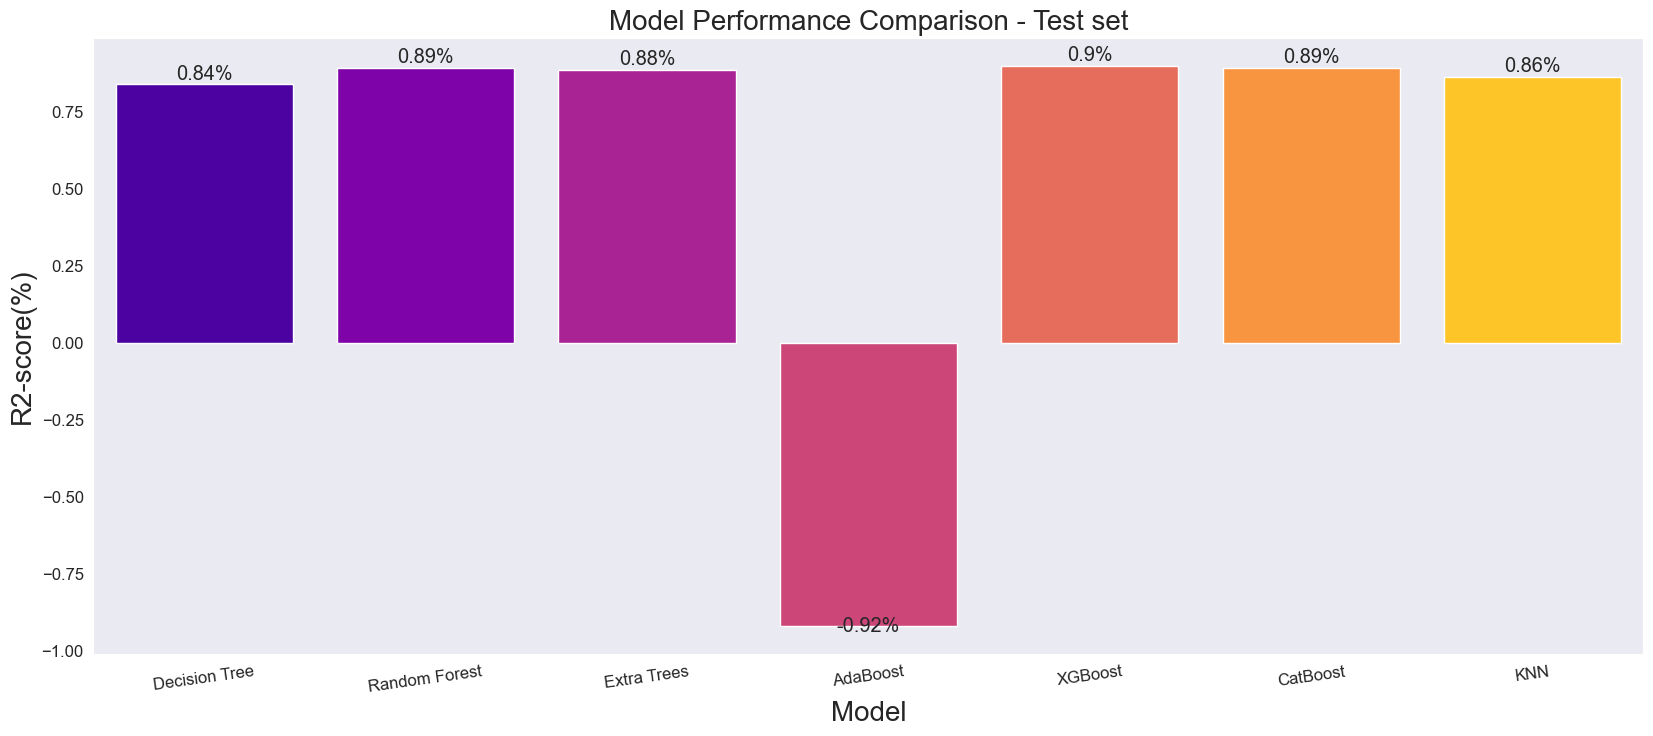

In [118]:
score_vis(scores)

En esta parte, usaré SHAP para explicar solo algunos modelos, comenzando con XGBoost.

In [119]:
xgrb_model = XGBRegressor(tree_method='hist', n_estimators=1000)
xgrb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [120]:
# Esto va a tardar 

xgbr_pred= xgrb_model.predict(X_test, output_margin=True)
explainer= shap.TreeExplainer(xgrb_model)
shap_values= explainer.shap_values(X_test)
np.abs(shap_values.sum(1) + explainer.expected_value - xgbr_pred).max() 

0.083984375

In [121]:
df.head(5)

price  abtest  vehicleType  gearbox  powerPS  model  kilometer  fuelType   
3    1500       1            4        1       75    117     150000         0  \
4    3600       1            4        1       69    102      90000         2   
5     650       1            6        1      102     11     150000         0   
6    2200       1            2        1      109      8     150000         0   
10   2000       0            6        1      105     10     150000         0   

    brand  notRepairedDamage  age  
3      37                  0   22  
4      31                  0   15  
5       2                  1   28  
6      25                  0   19  
10     19                  0   19

SHAP - XGBoost


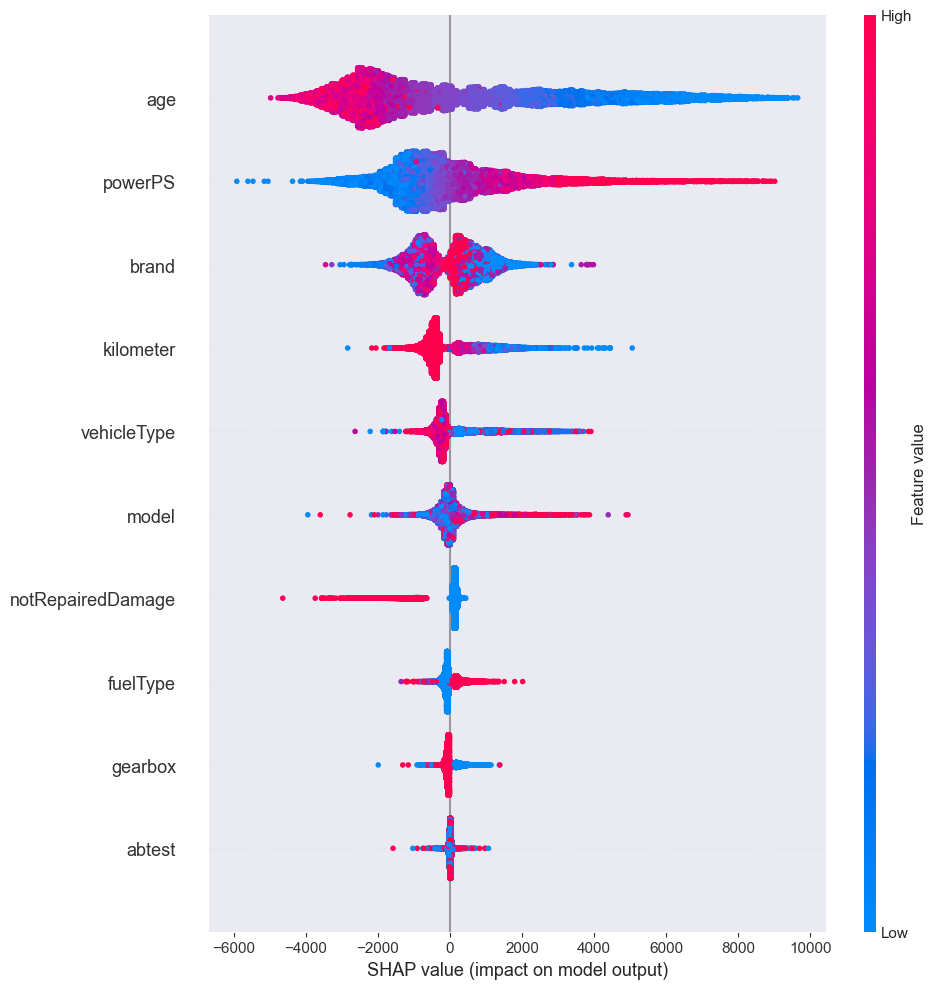

In [122]:
features_list = ['abtest','vehicleType','gearbox','powerPS','model','kilometer','fuelType','brand','notRepairedDamage','age']
print(Fore.BLUE + 'SHAP - XGBoost')
shap.summary_plot(shap_values=shap_values, features= X_test, feature_names=features_list, plot_size=(10,10)) # La configuración max_display=3 solo mostrará las 3 funciones principales.

Como se muestra, las características age y powerPS contribuyeron más a la predicción del modelo XGBoost Regressor. En caso de que desee visualizar menos funciones, defina el argumento max_display y establezca el número de las características principales que desea ver.
## CatBoost

In [124]:
cbr_model = CatBoostRegressor(logging_level='Silent')
cbr_model.fit(X_train, y_train)

cbr_pred = cbr_model.predict(X_test)
explainer_cbr = shap.TreeExplainer(cbr_model)
shap_values_cbr = explainer.shap_values(X_test)

SHAP - CatBoost



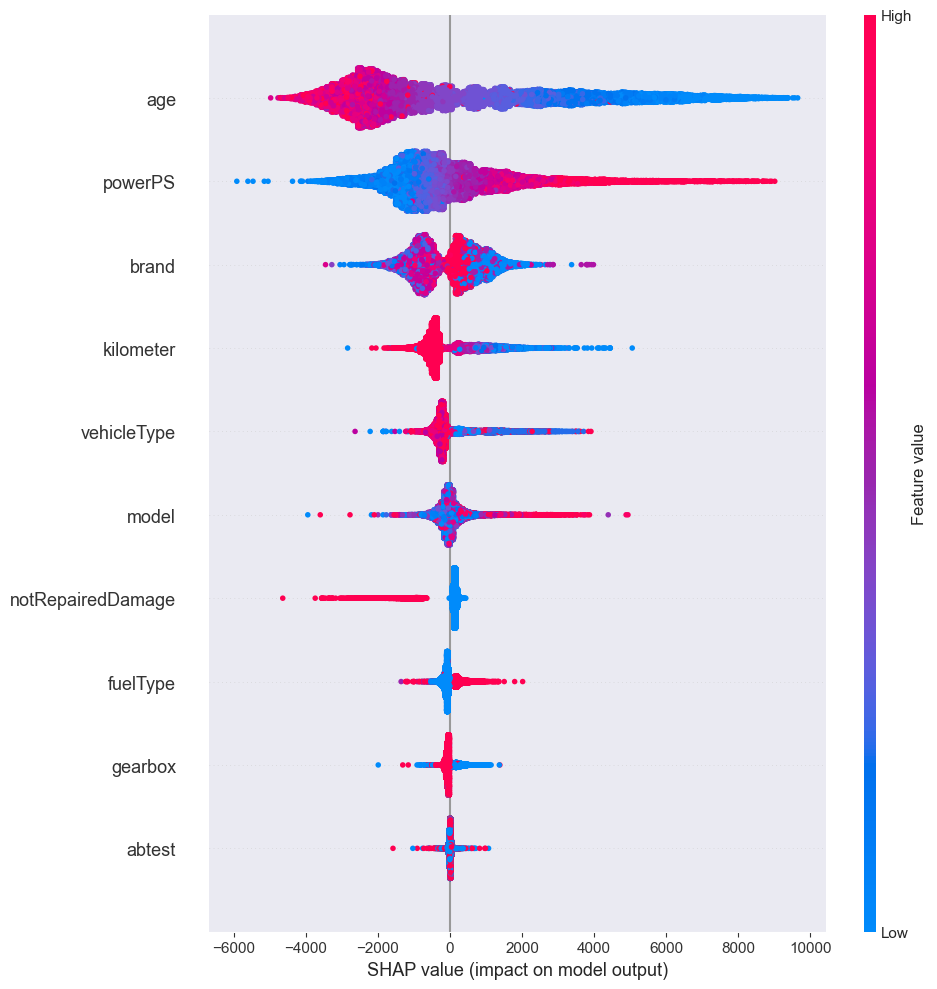

In [125]:
print(Fore.BLUE +'SHAP - CatBoost\n')
shap.summary_plot(shap_values = shap_values_cbr, features = X_test, feature_names=features_list, plot_size=(10,10))

Pasa lo mismo que en el modelo anterior
## Ensemble learning
1. Simple Averaging
2. Weighted Averaging --> I will manually wet the weights here based on my take from the previous step. Note that the weights must sum up to 1.
3. Voting
4. Stacking

In [129]:
dtr_model = DecisionTreeRegressor()
rfr_model = RandomForestRegressor(n_estimators=124)
etr_model = ExtraTreesRegressor(n_estimators=124)
xbr_model = XGBRegressor(tree_method='hist', n_estimators=1000)
cbr_model = CatBoostRegressor(logging_level='Silent')
knr_model = KNeighborsRegressor(weights='distance')

In [127]:
del dtr_model
del rfr_model
del etr_model
del xbr_model
del cbr_model
del knr_model

Averaging
1. Simple Average
2. Weighted Average

In [130]:
%%time

print('Fitting the Decision Tree model...\n')
dtr_model.fit(X_train, y_train)

print('Fitting the Random Forest model...\n')
rfr_model.fit(X_train, y_train)

print('Fitting the Extra Trees model...\n')
etr_model.fit(X_train, y_train)

print('Fitting the XGBRegressor model...\n')
xbr_model.fit(X_train, y_train)

print('Fitting the CatBoostRegressor model...\n')
cbr_model.fit(X_train, y_train)

print('Fitting the KNeighborsRegressor model...\n')
knr_model.fit(X_train, y_train)

Fitting the Decision Tree model...

Fitting the Random Forest model...

Fitting the Extra Trees model...

Fitting the XGBRegressor model...

Fitting the CatBoostRegressor model...

Fitting the KNeighborsRegressor model...

CPU times: total: 3min 11s
Wall time: 1min 28s


KNeighborsRegressor(weights='distance')

In [131]:
%%time

dtr_pred = dtr_model.predict(X_test)
rfr_pred = rfr_model.predict(X_test)
etr_pred = etr_model.predict(X_test)
xbr_pred = xbr_model.predict(X_test)
cbr_pred = cbr_model.predict(X_test)
knr_pred = knr_model.predict(X_test)

CPU times: total: 6.88 s
Wall time: 4.74 s


In [141]:
# 1. Promedio Simple
sum_preds = dtr_pred + rfr_pred + etr_pred + xbr_pred + cbr_pred + knr_pred
pred_final = np.round(sum_preds / 6)

print(Back.RED + Fore.BLACK + Style.BRIGHT + 'Simple Averaging Performance' + Back.RESET)

print(f"{Fore.BLUE}Test R2-Score: {Fore.RED}{r2_score(y_test, pred_final):.3f}")
print(f"{Fore.BLUE}Test MAE:      {Fore.RED}{mean_absolute_error(y_test, pred_final):.3f}")

Simple Averaging Performance
Test R2-Score: 0.899
Test MAE:      951.051


In [133]:
pred_final_w = np.round(0.4*xbr_pred + 0.2*cbr_pred + 0.2*rfr_pred + 0.1*etr_pred + 0.05*knr_pred + 0.05*dtr_pred)

In [142]:
# 2. Peso promedio

print(Back.RED + Fore.BLACK + Style.BRIGHT + 'Weighted Averaging Performance' + Back.RESET)

print(f"{Fore.BLUE}Test R2-Score: {Fore.RED}{r2_score(y_test, pred_final_w):.3f}")
print(f"{Fore.BLUE}Test MAE:      {Fore.RED}{mean_absolute_error(y_test, pred_final_w):.3f}")

Weighted Averaging Performance
Test R2-Score: 0.903
Test MAE:      934.308


## Voting


In [138]:
%%time

estimators = [('dtr', dtr_model), ('rfr', rfr_model), ('etr', etr_model),
              ('xbr', xbr_model), ('cbr', cbr_model), ('knr', knr_model)]

voting_model = VotingRegressor(estimators=estimators)

voting_model.fit(X_train, y_train)

voting_pred = voting_model.predict(X_test)

CPU times: total: 3min 16s
Wall time: 1min 34s


In [139]:
print(Back.RED + Fore.BLACK + Style.BRIGHT + 'Voting Performance' + Back.RESET)

print(f"{Fore.BLUE}Test R2-Score: {Fore.RED}{r2_score(y_test, voting_pred):.3f}")
print(f"{Fore.BLUE}Test MAE:      {Fore.RED}{mean_absolute_error(y_test, voting_pred):.3f}")

Voting Performance
Test R2-Score: 0.899
Test MAE:      951.655


## Stacking

In [140]:
%%time

final_estimator = GradientBoostingRegressor(random_state=666)

stacking_model = StackingRegressor(estimators=estimators, final_estimator=final_estimator)

stacking_model.fit(X_train, y_train)

stacking_pred = stacking_model.predict(X_test)

CPU times: total: 16min 47s
Wall time: 8min 13s


In [ ]:
print(Back.RED + Fore.BLACK + Style.BRIGHT + 'Stacking Performance' + Back.RESET)

print(f"{Fore.BLUE}Test R2-Score: {Fore.RED}{r2_score(y_test, stacking_pred):.3f}")
print(f"{Fore.BLUE}Test MAE:      {Fore.RED}{mean_absolute_error(y_test, stacking_pred):.3f}")

### Conclusion

En este cuaderno, analizamos un conjunto de datos de automóviles usados ​​y, en base a eso, realizamos un preprocesamiento de datos para realizar DL/ML.
Más tarde intentamos predecir el precio de un coche usado basándonos en varias características. Para esta tarea se utilizan un DNN y varios modelos de regresión. Esperaba que el modelo DNN superara al resto, sin embargo, el modelo XGBoost ofreció el mejor rendimiento.
Posteriormente utilizamos el marco SHAP para explicar dos de nuestros modelos.
Finalmente, se utilizaron diferentes técnicas de aprendizaje en conjunto. Sin embargo, este enfoque no logró superar a los demás, al menos en el caso del r2-score, aunque el MAE se redujo ligeramente al utilizar estos enfoques.

In this notebook, we analyzed a dataset of used cars, and based on that, performed data preprocessing for doing DL/ML.
We later tried to predict the price of a used car based on several features. A DNN and several regression models for used for this task. I was expecting the DNN model to outperform the rest, however, the XGBoost model offered the best performance.
We later used the SHAP framework to explain two of our models.
Finally, different ensemble learning techniques were used. However, this approach did not manage to outperform the other ones, at least in case of the R2-score, though the MAE was slightly decreased using these approaches.